In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['legend.fontsize'] = 14

import seaborn as sns
sns.set_style('whitegrid')

import json
import os

In [9]:
#dataPath = os.path.join('/Users/xliu/Documents/MRC/Work/Program/BayesianModelling/',
#                       'Bayesian-Modelling-in-Python-master/data/')

dataFile = 'hangout_chat_data.csv'

In [10]:
#dataOG = pd.read_csv(dataPath + dataFile)
dataOG = pd.read_csv(dataFile)
data = dataOG.copy()

In [11]:
data.shape

(338, 14)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338 entries, 0 to 337
Data columns (total 14 columns):
conversation_id       338 non-null object
event_id              338 non-null object
timestamp             338 non-null object
sender                338 non-null object
message_length        338 non-null int64
num_participants      338 non-null int64
message_type          338 non-null object
prev_timestamp        338 non-null object
prev_sender           338 non-null object
time_delay_seconds    338 non-null float64
time_delay_mins       338 non-null float64
day_of_week           338 non-null int64
year_month            338 non-null object
is_weekend            338 non-null int64
dtypes: float64(2), int64(4), object(8)
memory usage: 37.0+ KB


In [13]:
data.describe()

,message_length,num_participants,time_delay_seconds,time_delay_mins,day_of_week,is_weekend
count,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000
mean,32.946746,2.153846,18.230769,0.979290,2.304734,0.097633
std,31.502863,0.511006,13.904720,0.142623,1.664441,0.297258
min,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,2.000000,8.000000,1.000000,1.000000,0.000000
50%,24.000000,2.000000,14.000000,1.000000,2.000000,0.000000
75%,45.000000,2.000000,25.750000,1.000000,3.000000,0.000000
max,198.000000,4.000000,58.000000,1.000000,6.000000,1.000000


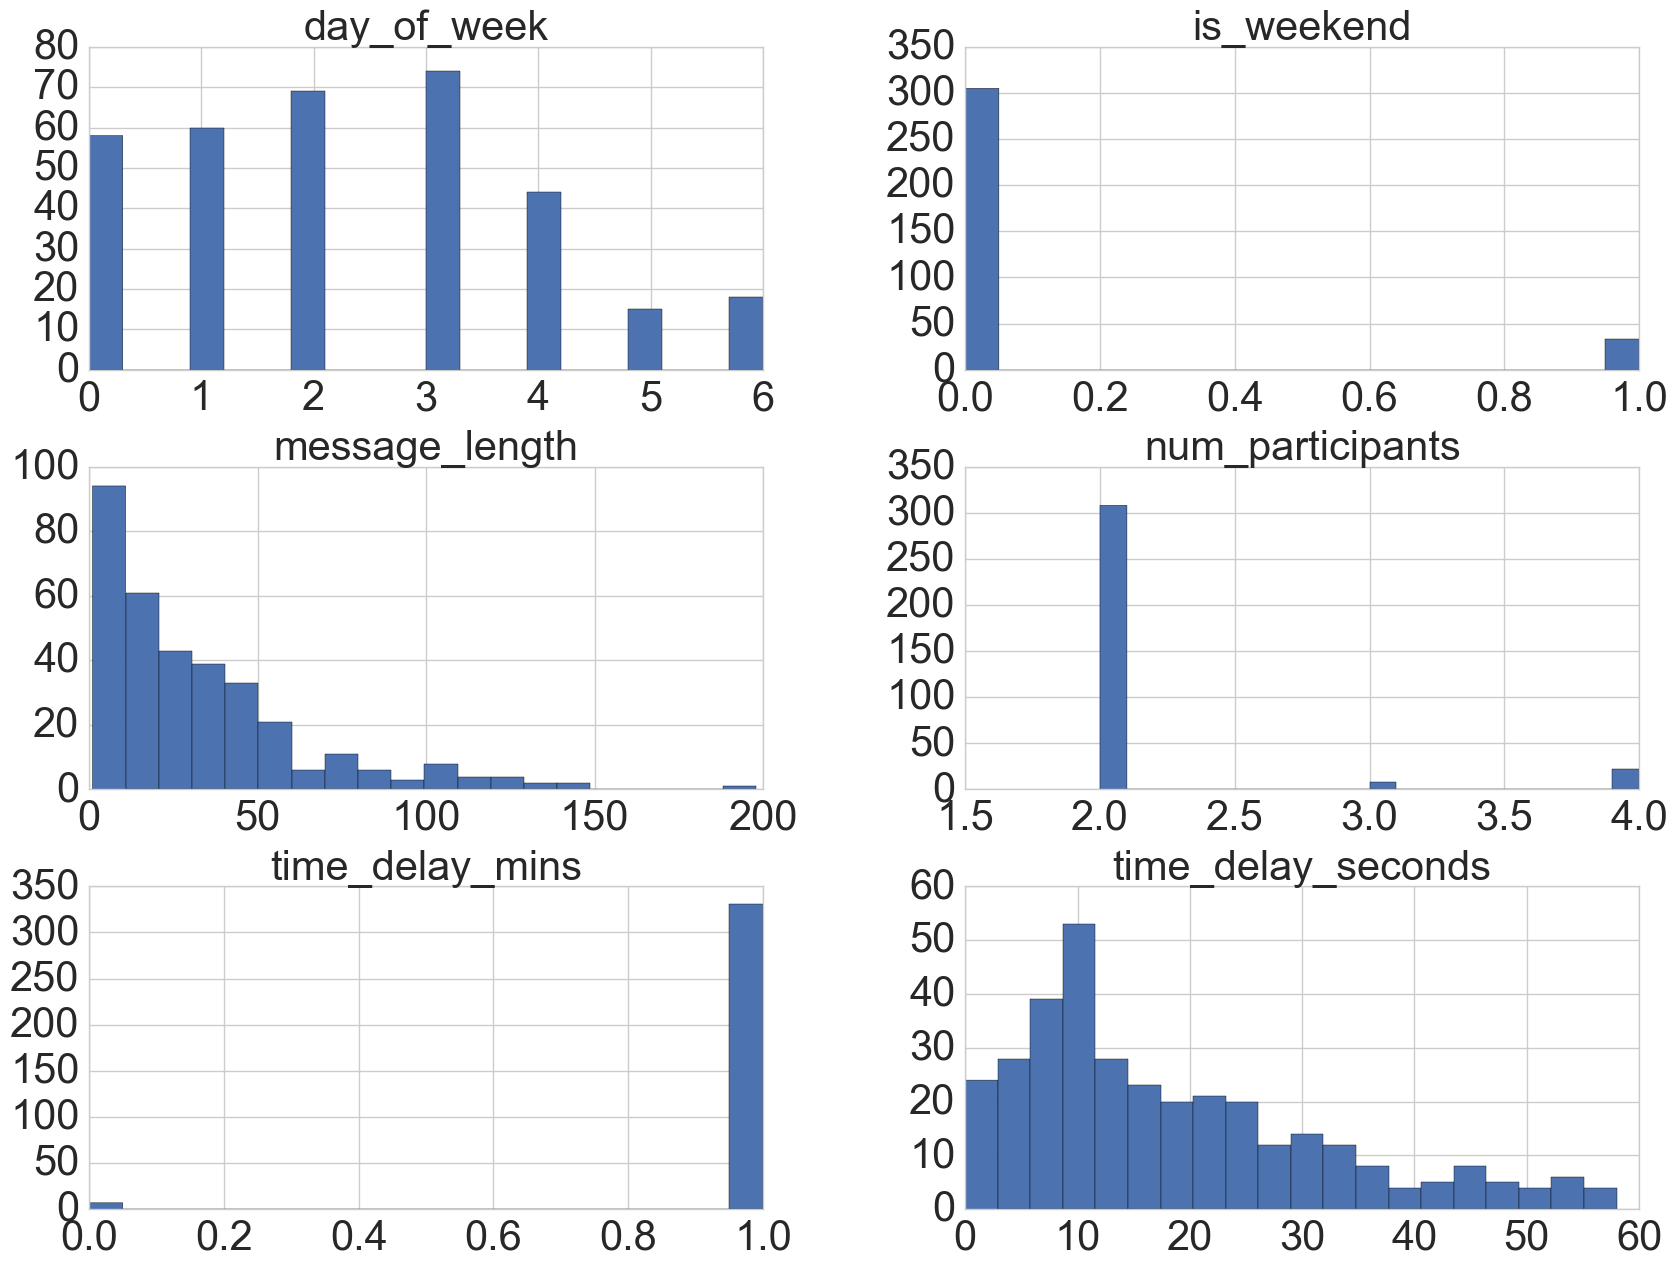

In [14]:
data.hist(bins=20, figsize=(20,15));

In [15]:
data.head(2)

,conversation_id,event_id,timestamp,sender,message_length,num_participants,message_type,prev_timestamp,prev_sender,time_delay_seconds,time_delay_mins,day_of_week,year_month,is_weekend
0,Ugw5Xrm3ZO5mzAfKB7V4AaABAQ,7-H0Z7-FkyB7-HDBYj4KKh,2014-08-15 03:44:12.840015,Mark Regan,14,3,TEXT,2014-08-15 03:44:00.781653,Keir Alexander,12.0,1.0,4,2014-08,0
1,UgwLUkm5oqPrUyjqFlR4AaABAQ,85SWvmXIEV285Sb1E65xL0,2015-10-18 09:36:39.438706,Mark Regan,47,4,TEXT,2015-10-18 09:36:10.932367,Louise Regan,28.0,1.0,6,2015-10,1


### response time

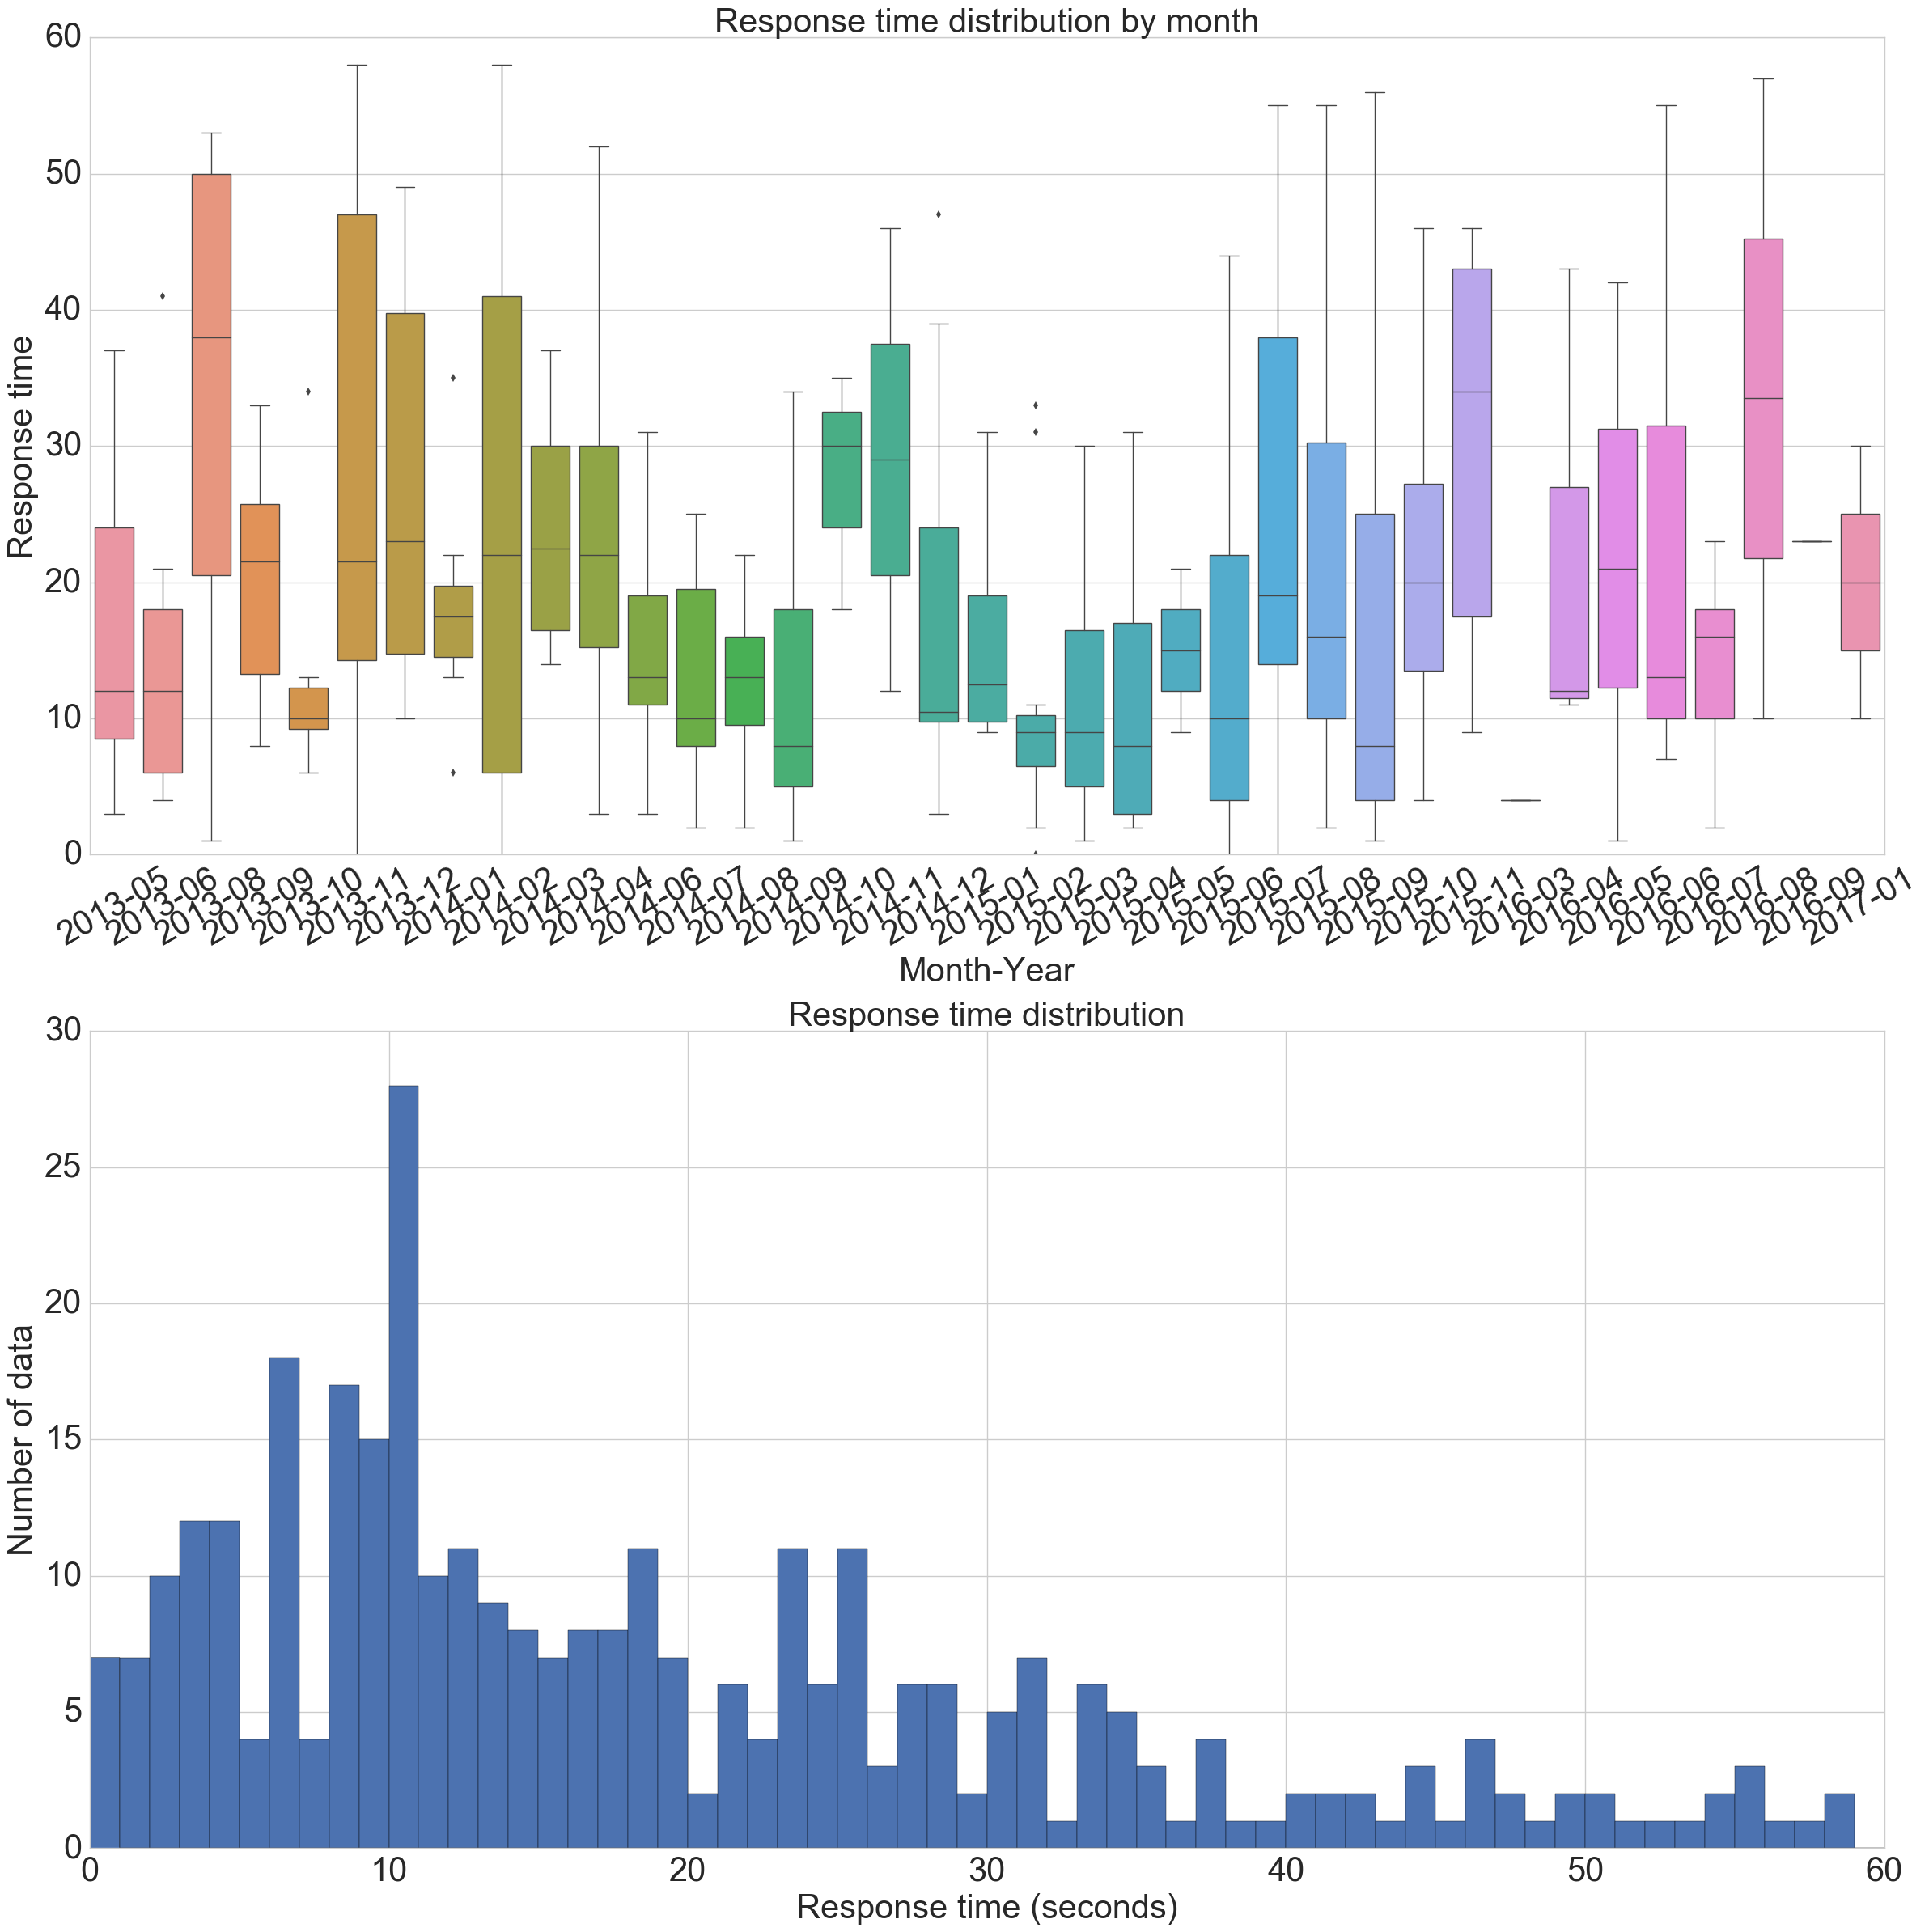

In [16]:
fig = plt.figure(figsize=(24,24))
ax1  = plt.subplot(211)

order = np.sort(data['year_month'].unique())
sns.boxplot(x=data['year_month'], y=data['time_delay_seconds'],order=order, orient='v', linewidth=1, ax=ax1)
_ = ax1.set_title('Response time distribution by month')
_ = ax1.set_xlabel('Month-Year')
_ = ax1.set_ylabel('Response time')
_ = plt.xticks(rotation=30)

ax2 = plt.subplot(212)
plt.hist(data['time_delay_seconds'].values, range=[0, 60], bins = 60)
_ = ax2.set_title('Response time distribution')
_ = ax2.set_xlabel('Response time (seconds)')
_ = ax2.set_ylabel('Number of data')

plt.tight_layout()

# Section 2. Estimating model parameters

In [18]:
import pymc3 as pm
import scipy.stats as stats
import scipy.optimize as opt

## three Poisson distributions with three mean/variance

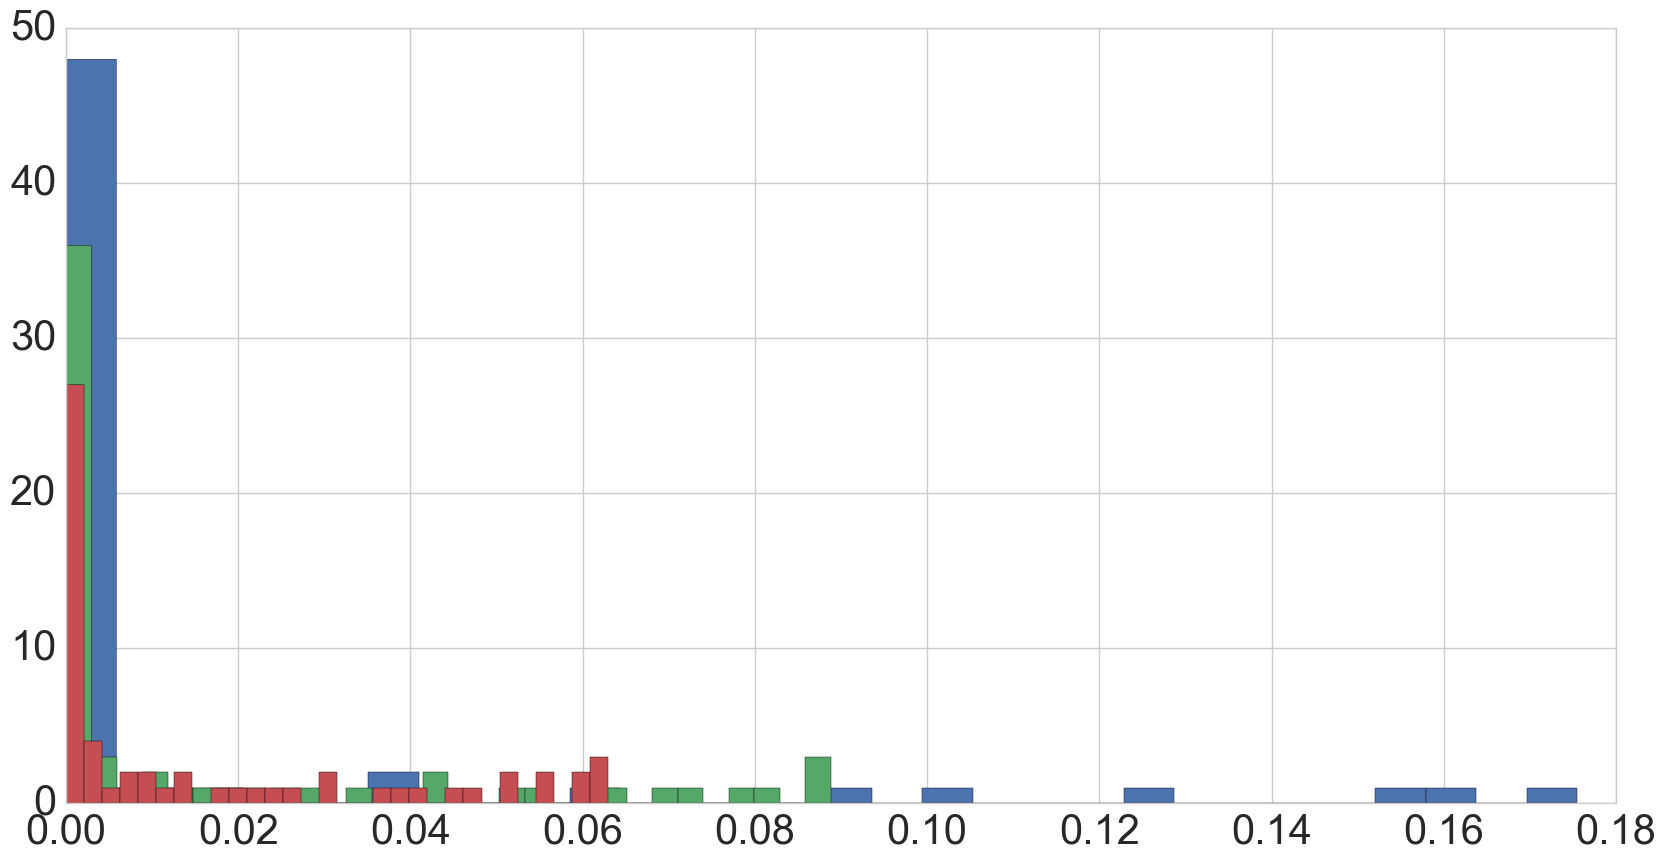

In [19]:
plt.figure(figsize=(20,10))
x     = range(60)
mu    = [5, 20, 40]

poi_dis_1 = stats.poisson.pmf(mu[0], x)
poi_dis_2 = stats.poisson.pmf(mu[1], x)
poi_dis_3 = stats.poisson.pmf(mu[2], x)

plt.hist(poi_dis_1, bins=30);
plt.hist(poi_dis_2, bins=30);
plt.hist(poi_dis_3, bins=30);

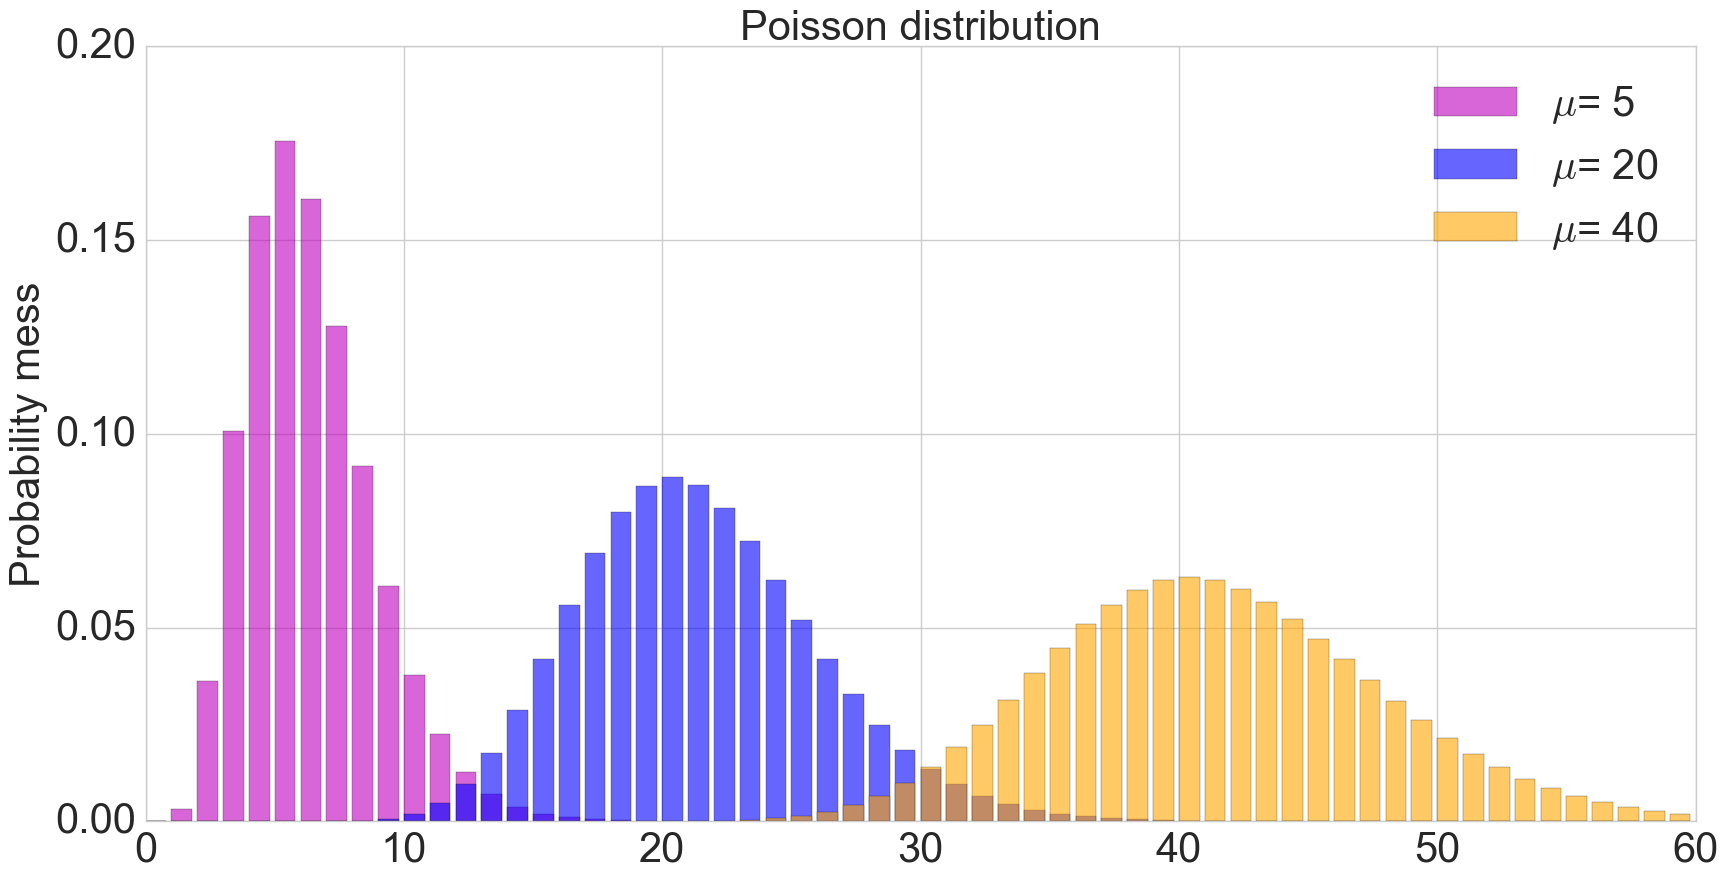

In [20]:
plt.figure(figsize=(20,10))
ax = plt.subplot(111)
for n in range(60):
    plt.bar(n, stats.poisson.pmf(mu[0], n), color = 'm', alpha=0.6)
    plt.bar(n, stats.poisson.pmf(mu[1], n), color = 'b', alpha=0.6)
    plt.bar(n, stats.poisson.pmf(mu[2], n), color = 'orange', alpha=0.6)

ax.set_xlim(0, 60)
ax.set_ylim(0, 0.2)
ax.set_ylabel('Probability mess')
ax.set_title('Poisson distribution')
plt.legend(['$\mu$= %s' % mu[0],'$\mu$= %s' % mu[1],'$\mu$= %s' % mu[2]]);

## Frequentists method of estimating the $\mu$ of response time

Given that response_time is count data, we can model it as a Poisson distribution and estimate its parameter $\mu$. We will explore both a frequentist and Bayesian method of estimating this parameter.

First look at a frequentist method of estimating the parameters of a Poisson distribution. It is able to use an optimization technique that aims to maximize the likelihood of a function.
The below function poisson_logprob() returns the overall likelihood of the observed data given a Poisson model and parameter value. We use the method opt.minimize_scalar to find the value of $\mu$ that is most credible (maximizes the log likelihood) given the data observed. Under the hood, this optimization technique is intelligently iterating through possible values of mu until it finds a value with the highest likelihood.

In [21]:
yobs = data['time_delay_seconds'].values

In [22]:
# negative log-Poisson
def poisson_logprob(y, mu, sign=-1):
    poi_log_pmf = stats.poisson.logpmf(y, mu)
    poi_logprob = np.sum(sign * poi_log_pmf)
    return poi_logprob

In [23]:
poi_loglik = lambda mu: poisson_logprob(yobs, mu)

In [24]:
freq_results = opt.minimize_scalar(poi_loglik)

In [26]:
%time print('The estimated value of mu is: %s' % freq_results['x'])

The estimated value of mu is: 18.2307692324
Wall time: 0 ns


This frequentist solution has no any measure of uncertainty, and it is just a point value. However, it is very efficient.

The below plot illustrates the function that we are optimizing. At each value $\mu$, the plot shows the log-probability at $\mu$ given the data and the model. The optimizer works in a hill climbing fashion - starting at a random point on the curve and incrementally climbing until it cann't get to a higher point.

In [27]:
x = np.linspace(1, 60)
ymin = np.min([poisson_logprob(yobs, i, sign=1) for i in x])
ymax = np.max([poisson_logprob(yobs, i, sign=1) for i in x])

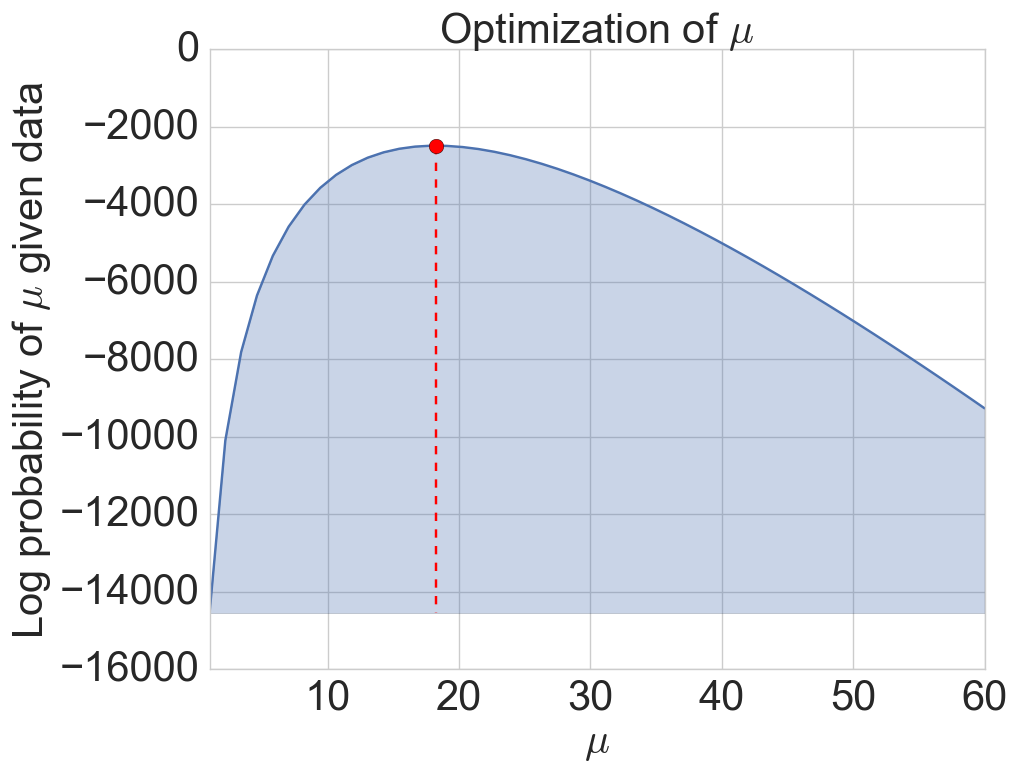

In [28]:
fig = plt.figure(figsize=(10, 8))
plt.plot(x, [poisson_logprob(yobs, i, sign=1) for i in x])
plt.fill_between(x, [poisson_logprob(yobs, i, sign=1) for i in x], ymin, alpha=0.3)

plt.title('Optimization of $\mu$')
plt.xlabel('$\mu$')
plt.ylabel('Log probability of $\mu$ given data')
plt.vlines(freq_results['x'], ymax, ymin, colors='red', linestyles='dashed')
plt.scatter(freq_results['x'], ymax, s=110, c='red', zorder=3)
#plt.ylim(ymin=ymin, ymax=ymax)
plt.xlim(xmin=1, xmax=60);

Plot out the Poisson distribution given the $\mu_{ML}$

In [29]:
x_range = 60
x = range(x_range)

In [30]:
mu_ML = np.int(freq_results['x'])

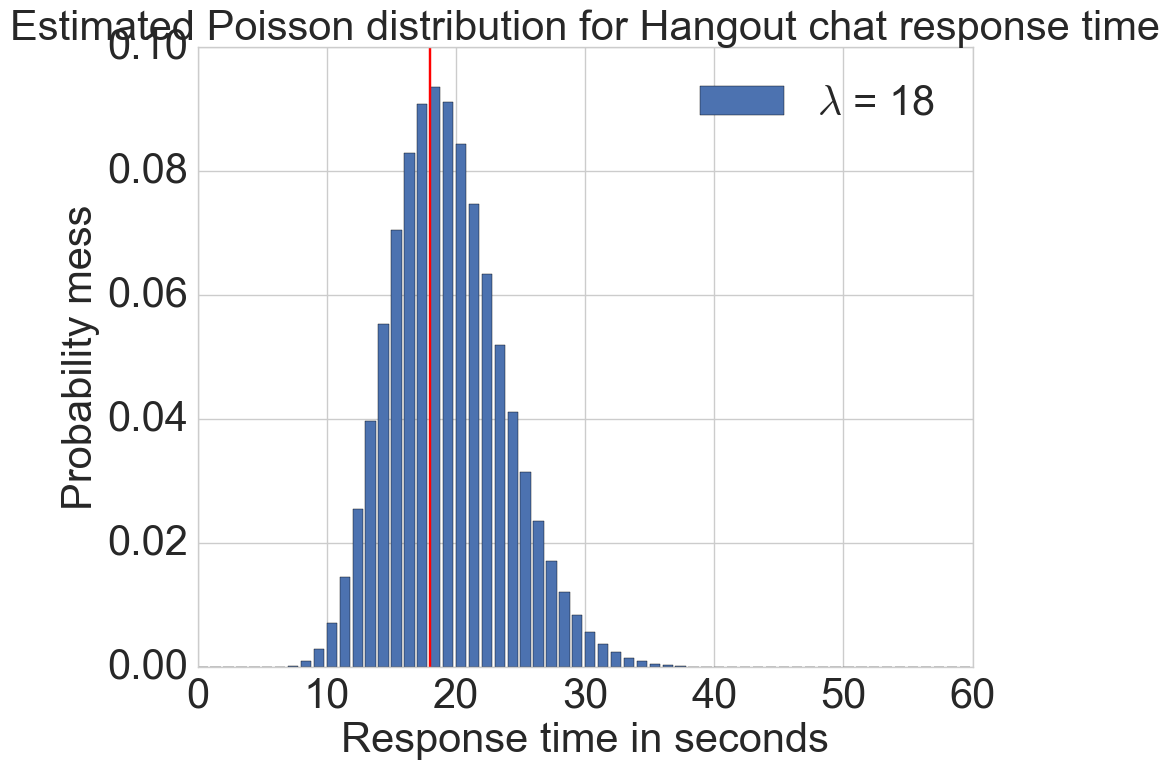

In [31]:
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(111)
for n in x:
    plt.bar(n, stats.poisson.pmf(mu_ML, n))

ax.set_xlabel('Response time in seconds')
ax.set_ylabel('Probability mess')
ax.set_xlim(0, 60)
ax.set_ylim(0, 0.1)
ax.set_title('Estimated Poisson distribution for Hangout chat response time')
plt.legend(['$\lambda$ = %s' % mu_ML]);
plt.vlines(mu_ML, 0, 0.1, colors = 'r');

The above Poisson model and estimated value of μ suggest that there is minimal chance of an observation less than 10 or greater than 30. The vast majority of the probability mass is between 10 and 30. However, we know this is not reflected in the data that we observed - which has observed values between 0 and 60 (according to histogram of time_delay_seconds attribute).

# Bayesian method of estimating $\mu$

In [32]:
with pm.Model() as model:
    mu = pm.Uniform('mu', lower=0, upper=60)
    likelihood = pm.Poisson('likelihood', mu=mu, observed=data['time_delay_seconds'].values)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(200000, step, start=start, progressbar=True)

Optimization terminated successfully.
         Current function value: 2487.323198
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6


100%|████████████████████████████████| 200000/200000 [00:20<00:00, 9876.23it/s]


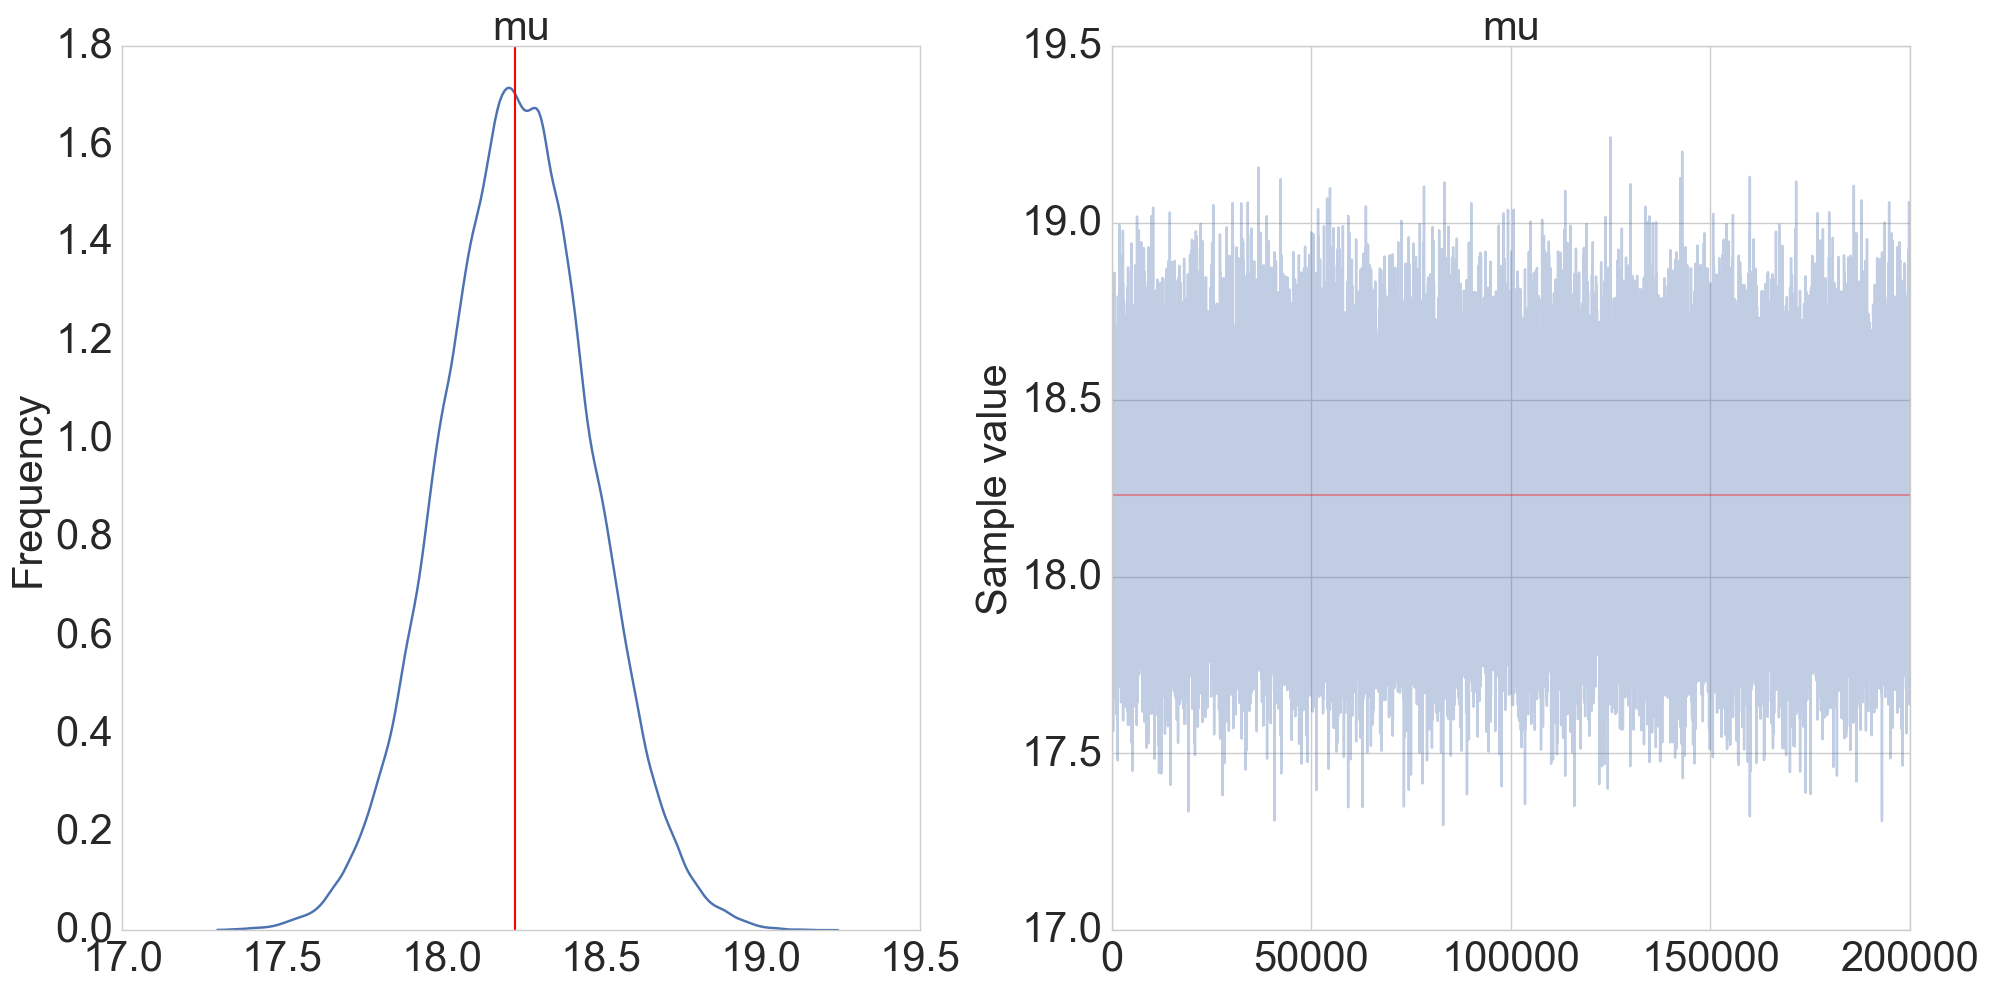

In [33]:
pm.traceplot(trace, varnames=['mu'], lines={'mu':freq_results['x']}, figsize=(20,10));

In the code, we set the initialization (start) as result from MAP() -- maximum a posterior estimator. By setting the starting point as the result from MAP, it helps MCMC sampler find a good place from which to start sampling. Conceptually, it will start the MH in an area of high likelihood. 

# Model convergence

## Trace
Just because the above model estimated a value for $\mu$, doesn't mean the model estimated a good value given the data. There are some recommended checks that you can make. Firstly, look at the trace output. You should see the trace jumping around and generally looking like a hairy caterpillar. If you see the trace snake up and down or appear to be stuck in any one location - it is a sign that you have convergence issues and the estimations from the MCMC sampler cannot be trusted.
## Autocorrelation plot
The second test you can perform is the autocorrelation test (see below plot). It is a measure of correlation between successive samples in the MCMC sampling chain. When samples have low correlation with each other, they are adding more "information" to the estimate of your parameter value than samples that are highly correlated.
Visually, you are looking for an autocorrelation plot that tapers off to zero relatively quickly and then oscilates above and below zero correlation. If your autocorrelation plot does not taper off - it is generally a sign of poor mixing and you should revisit your model selection (eg. likelihood) and sampling methods (eg. Metropolis).

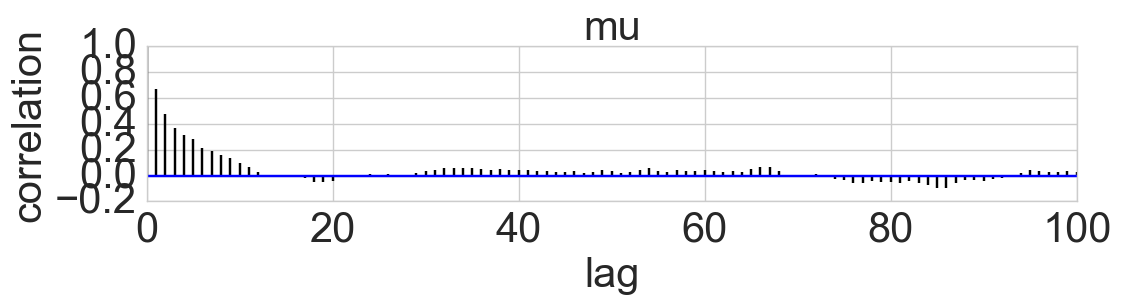

In [34]:
pm.autocorrplot(trace[:2000], varnames=['mu']);

# Section 3. Model checking

The posterior predictive check requires one to generate new data from the predicted model. What does that mean? Well, we have estimated 200,000 credible values of $\mu$ for the Poisson distribution. That means we can construct 200,000 Poisson distributions with these values and then randomly sample from these distributions. This is formally represented as:

$$p(\tilde{y}|y) = \int p(\tilde{y}|\theta) f(\theta|y) d\theta$$

Conceptually, if the model is a good fit for the underlying data - then the generated data should resemble the original observed data. PyMC provides a convenient way to sample from the fitted model. You may have noticed a new line in the above model specification: 

`y_pred = pm.Poisson('y_pred', mu=mu)`

In [35]:
with pm.Model() as model:
    mu = pm.Uniform('mu', lower = 0, upper = 60)
    yest  = pm.Poisson('yest', mu = mu, observed = data['time_delay_seconds'].values)
    ypred = pm.Poisson('ypred', mu = mu)
    
    start = pm.find_MAP()
    step  = pm.Metropolis()
    trace = pm.sample(200000, step, start=start, progressbar=True)

Optimization terminated successfully.
         Current function value: 2493.106610
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6


100%|████████████████████████████████| 200000/200000 [00:30<00:00, 6532.39it/s]


In [39]:
x_num   = 60
x_range = range(x_num)

In [40]:
# define a burn-in 
burnin = 50000

# retrieve traces for ypred
ypred = trace[burnin:].get_values('ypred')

# retrieve traces for mu
mu = trace[burnin:].get_values('mu')

Plot the predicted output $\hat{y}$ versus really observation y 

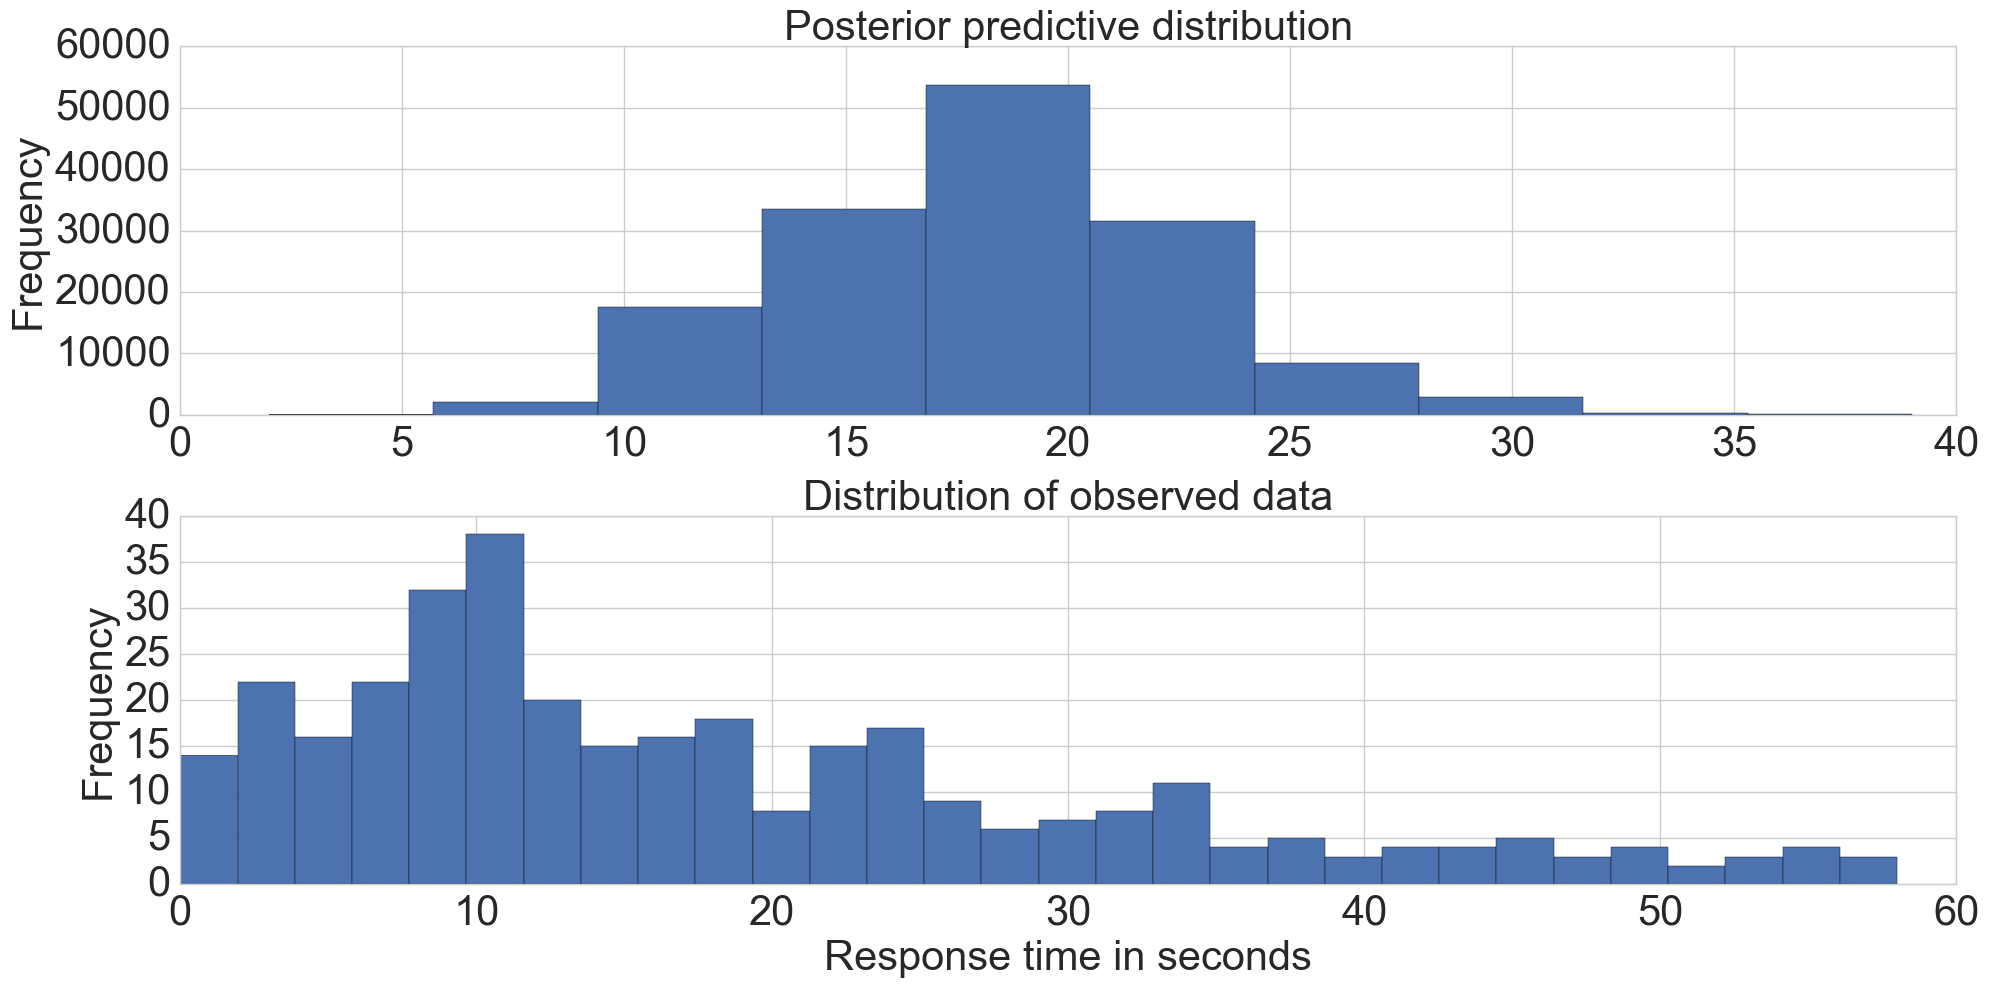

In [41]:
fig = plt.figure(figsize=(20, 10))

ax1 = plt.subplot(211)
ax1.hist(ypred);
ax1.set_ylabel('Frequency')
ax1.set_title('Posterior predictive distribution')

ax2 = plt.subplot(212)
ax2.hist(data['time_delay_seconds'], bins = 30)
ax2.set_xlabel('Response time in seconds')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of observed data')

plt.tight_layout()

Ideally, the posterior predictive distribution to somewhat resemble the distribution of the observed data. Intuitively, if we have correctly estimated the parameters of the model, then we should be able to sample similar data from that model. Clearly this is not the case.
Perhaps the Poisson distribution is not suitable for this data. One alternative option we have is the Negative Binomial distribution. This has very similar characteristics to the Poisson distribution except that it has two parameters ($\mu$ and $\alpha$) which enables it to vary its variance independently of its mean. Recall that the Poisson distribution has one parameter ($\mu$) that represents both its mean and its variance.

In [42]:
a = [2, 4]
mu = [15, 40]

In [43]:
def get_n(mu, alpha):
    return 1/alpha * mu

In [44]:
def get_p(mu, alpha):
    return get_n(mu, alpha) / (get_n(mu, alpha) + mu)

In [49]:
print(get_n(mu[0], a[0]))
print(get_n(mu[1], a[1]))

7.5
10.0


In [50]:
print(get_p(mu[0], a[0]))
print(get_p(mu[1], a[1]))

0.3333333333333333
0.2


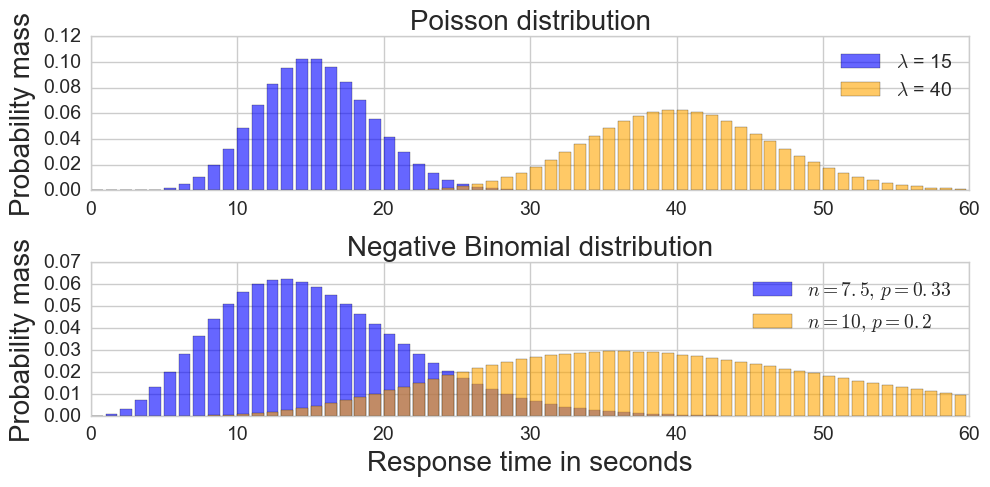

In [77]:
fig = plt.figure(figsize=(10, 5))

ax1 = plt.subplot(211)
mu = [15, 40]
for n in x_range:
    plt.bar(n, stats.poisson.pmf(n, mu[0]), color='b', alpha=0.6)
    plt.bar(n, stats.poisson.pmf(n, mu[1]), color='orange', alpha=0.6)
ax1.set_ylabel('Probability mass')
ax1.set_title('Poisson distribution')
ax1.legend(['$\lambda$ = %s' % mu[0],
                '$\lambda$ = %s' % mu[1]])

ax2 = plt.subplot(212)
for n in x_range:
    plt.bar(n, stats.nbinom.pmf(n, 7.5, 0.33), color='b', alpha=0.6)
    plt.bar(n, stats.nbinom.pmf(n, 10, 0.2), color='orange', alpha=0.6)

ax2.set_xlabel('Response time in seconds')
ax2.set_ylabel('Probability mass')
ax2.set_title('Negative Binomial distribution')
ax2.legend(['$n = %s, \/ p = %s$' % (7.5, 0.33),
            '$n = %s, \/ p = %s$' % (10, 0.2)])

plt.tight_layout()

Estimate the parameters for a Negative Binomial distribution given the same dataset used before. Again, we will use a Uniform distribution to estimate both $\mu$ and $\alpha$. The model can be represented as:

$$y_{j} \sim NegBinomial(\mu, \alpha)$$
$$\alpha = Exponential(0.2)$$
$$\mu = Uniform(0,100)$$

In [70]:
with pm.Model() as model:
    alpha = pm.Exponential('alpha', lam=.2)
    mu    = pm.Uniform('mu', lower = 0, upper = 100)
    
    # define likelihood: yest|y -- negative Binomial
    # define likelihood: ypred|\hat{\mu}, \hat(\labmda) -- negative Binomial
    yest = pm.NegativeBinomial('yest', mu = mu, alpha = alpha, observed = data['time_delay_seconds'].values)
    ypred = pm.NegativeBinomial('ypred', mu = mu, alpha = alpha)
    
    # define starting point and sampler used
    start = pm.find_MAP()
    step  = pm.Metropolis()
    
    # sample trace
    iterNum = 200000
    trace = pm.sample(iterNum, step, start = start, progressbar=True)

Optimization terminated successfully.
         Current function value: 1317.850733
         Iterations: 9
         Function evaluations: 15
         Gradient evaluations: 15


100%|████████████████████████████████| 200000/200000 [01:06<00:00, 3017.12it/s]


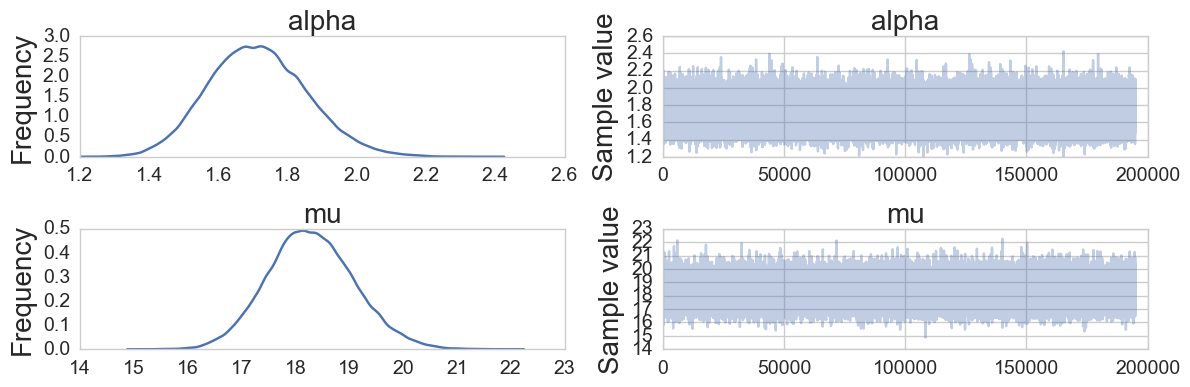

In [78]:
burnin = 5000
pm.traceplot(trace[burnin:], varnames=['alpha', 'mu']);

In [96]:
alpha_est = trace[burnin:].get_values('alpha')
mu_est = trace[burnin:].get_values('mu')

alpha_est_mean = np.mean(alpha_est)
mu_est_mean = np.mean(mu_est)

print('mean of estimated alpha = {0:1f}'.format(alpha_est_mean))
print('mean of estimated mu = {0:1f}'.format(mu_est_mean))

mean of estimated alpha = 1.712590
mean of estimated mu = 18.296536


Compare predictive outputs $\hat{y}$ given assuming it is modelled as negative binomial, to the true observation y

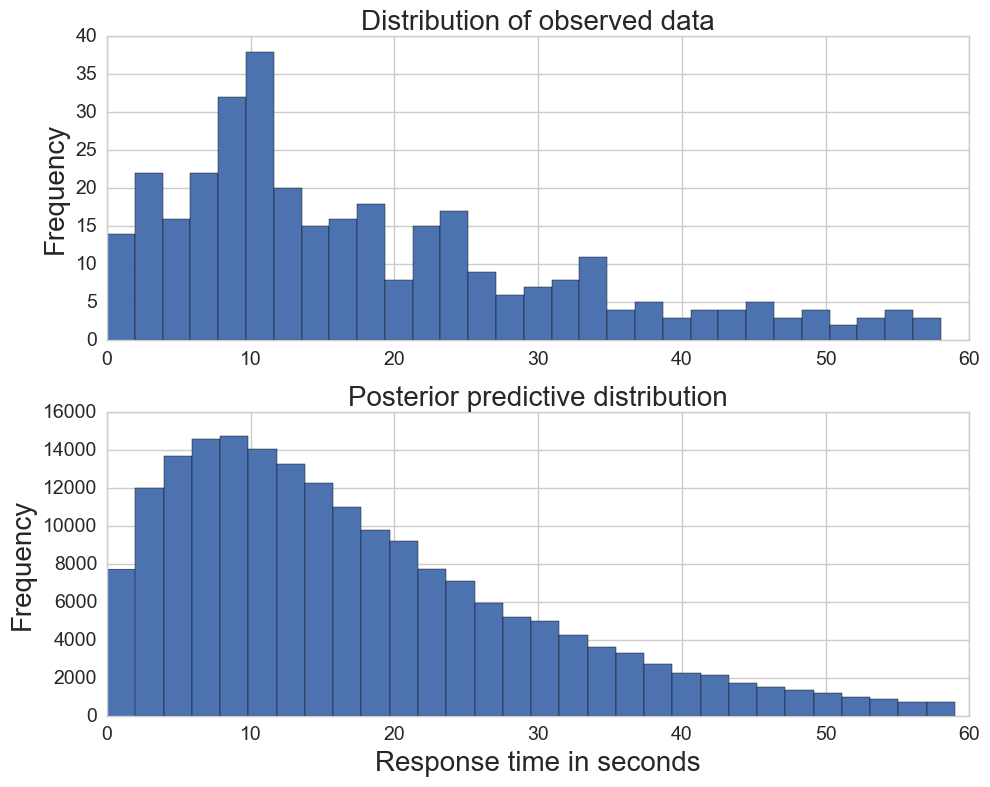

In [82]:
fig = plt.figure(figsize=(10, 8))

ax1 = plt.subplot(211)
plt.hist(data['time_delay_seconds'], bins = 30)
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of observed data')

ax2 = plt.subplot(212)
ypred_nbinom = trace[burnin:].get_values('ypred')
plt.hist(ypred_nbinom, bins = 30, range=[0, max(x_range)])
ax2.set_xlabel('Response time in seconds')
ax2.set_ylabel('Frequency')
ax2.set_title('Posterior predictive distribution')
ax2.legend(['$n = %s, \/ p = %s$' % (7.5, 0.33)])
    

plt.tight_layout()

these two distributions are looking more similar to one another (much better than binomial VS observed). As per the posterior predictive check, this would suggest that the Negative binomial model is a more appropriate fit for the underlying data. 

Another quantative measure of model check is Bayes factor. 

### Model Check II: Bayes Factor

Another modeling technique is to compute the Bayes factor. This is an analytical method that aims to compare two models with each other.

The Bayes factor was typically a difficult metric to compute because it required integrating over the full joint probability distribution. In a low dimension space, integration is possible but once you begin to model in even modest dimensionality, integrating over the full joint posterior distribution becomes computationally costly and time-consuming.

There is an alternative and analogous technique for calculating the Bayes factor. It involves taking your two models for comparison and combining them into a hierarchical model with a model parameter index ($\tau$). This index will switch between the two models throughout the MCMC process depending on which model it finds more credible. As such, the trace of the model index tells us a lot about the credibility of model M1 over model M2.

In [97]:
from IPython.display import Image

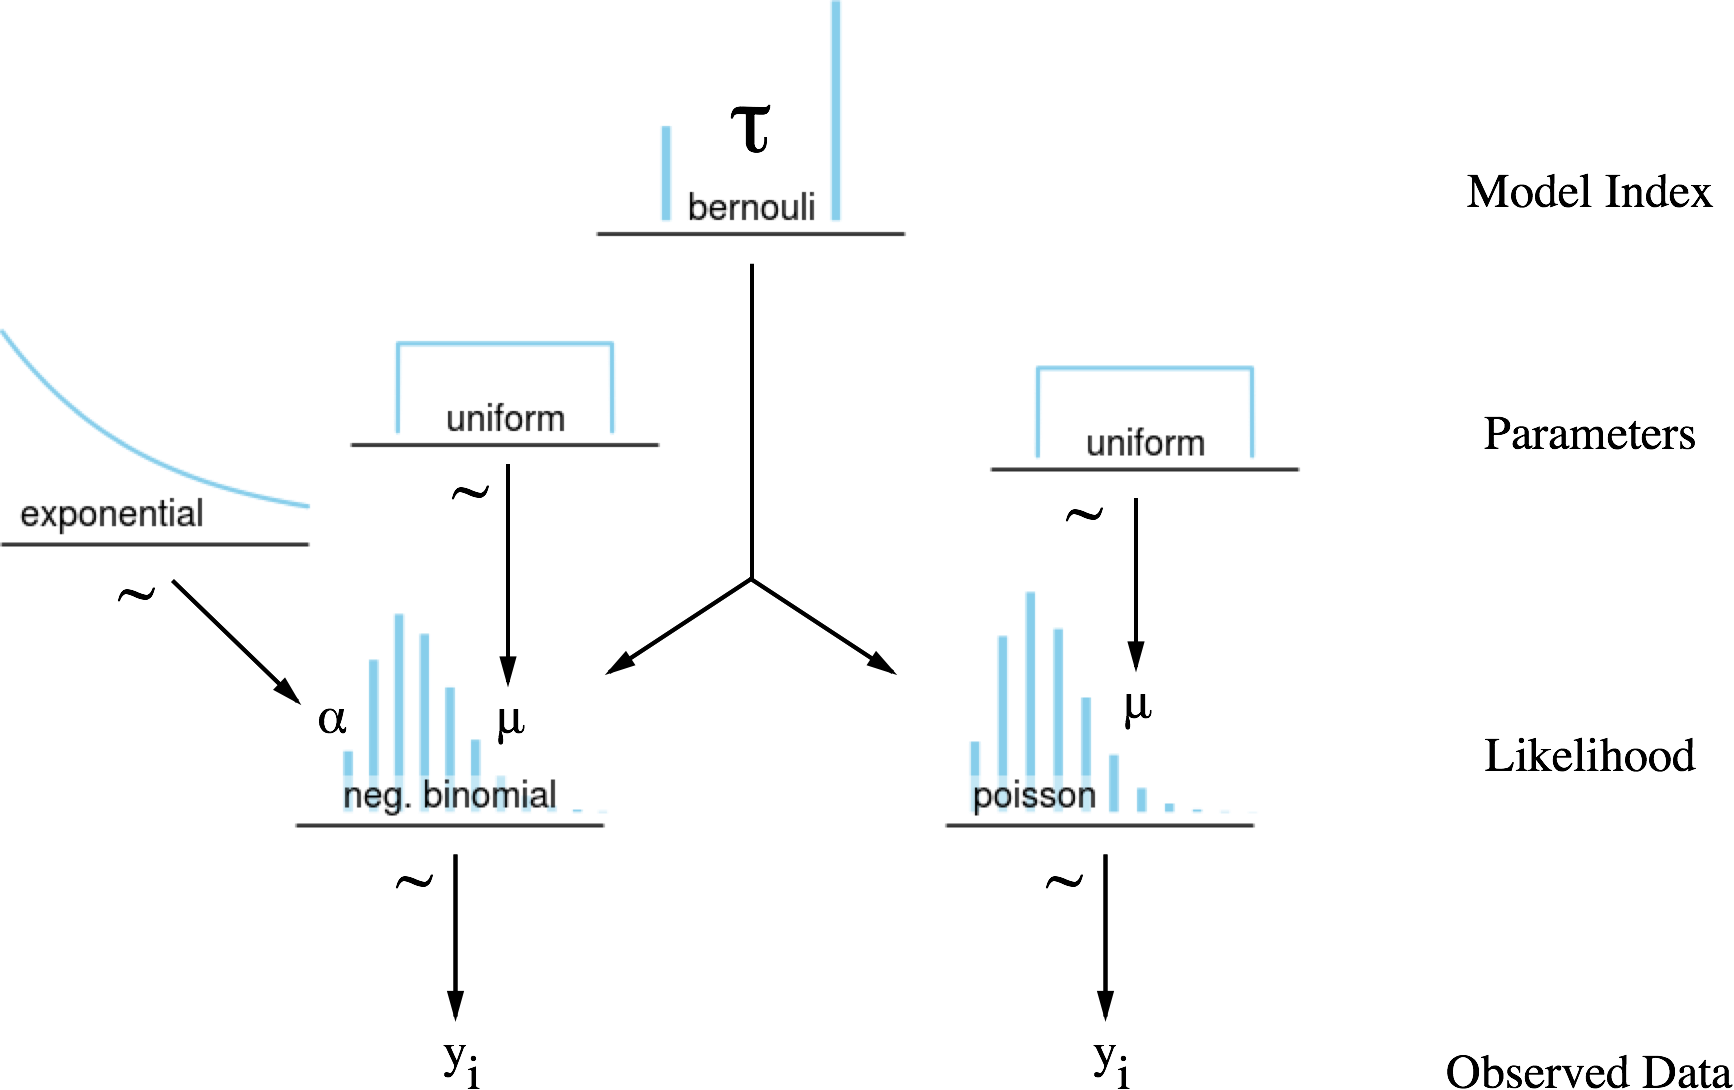

In [98]:
Image('Bayes Factor DAG.png', width=540)

In [106]:
with pm.Model() as model:
    
    # index of better model
    prior_model_prob = 0.5
    
    # estimate the model index -- tau
    tau = pm.Bernoulli('tau', prior_model_prob)
    
    # estimate the parameter for model M1 -- Poisson(lambda)
    lambda_poisson_m1 = pm.Uniform('lambda', lower = 0, upper = 60)
    
    # estimate parameters for model M2 -- negative binomial negb(mu, alpha)
    alpha_negbinom_m2 = pm.Exponential('alpha', lam = 0.2) # prior of hyperparameter - alpha of negative binomial -- exponential
    mu_negbiom_m2 = pm.Uniform('mu', lower = 0, upper = 60) # prior of hyperparameter - mu of negative binomial -- uniform
    
    # calculate the 'likelihood'
    ylike = pm.DensityDist('ylike', \
                           lambda value: pm.math.switch(tau, pm.Poisson.dist(lambda_poisson_m1).logp(value), pm.NegativeBinomial.dist(mu_negbiom_m2, alpha_negbinom_m2).logp(value))\
                           , observed=data['time_delay_seconds'].values)
    
    # define starting point, sampler for hyper-parameter, sampler for model index
    start = pm.find_MAP()
    step1 = pm.Metropolis([lambda_poisson_m1, alpha_negbinom_m2, mu_negbiom_m2])
    step2 = pm.ElemwiseCategorical(vars=[tau], values=[0,1])
    trace = pm.sample(200000, step=[step1, step2], start=start, progressbar=True)

Optimization terminated successfully.
         Current function value: 2490.402639
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6


C:\Users\xinliu\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
100%|████████████████████████████████| 200000/200000 [02:11<00:00, 1524.74it/s]


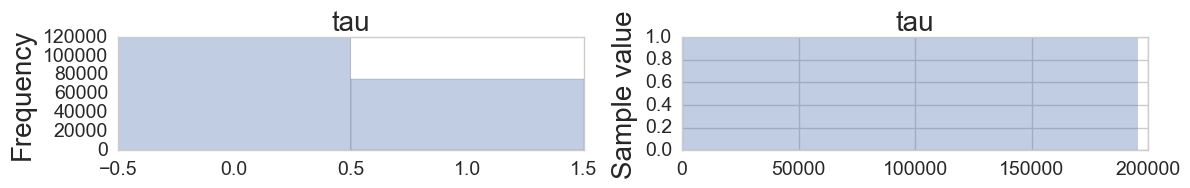

In [108]:
pm.traceplot(trace[burnin:], varnames=['tau']);

We can calculate the Bayes Factor for the above two models using the below formulation:

$$Posterior Odds = Bayes Factor * Prior Odds$$

$$\frac{P(Data \ | \ M_{1})}{P(Data \ | \ M_{2})} = B.F. \times \frac{P(M_{1})}{P(M_{2})}$$

In the above example, we didn't apply prior probability to either model, hence the Bayes Factor is simply the quotient of the model likelihoods. If you find that your MCMC sampler is not traversing between the two models, you can introduce prior probabilities that will help you get sufficient exposure to both models.

In [112]:
# Compute the Bayes factor
prob_pois = trace[burnin:]['tau'].mean()
prob_nb = 1 - prob_pois
BF = (prob_pois/prob_nb)*(prior_model_prob/(1-prior_model_prob))
#BF = (prob_nb/prob_pois)*(prior_model_prob/(1-prior_model_prob))
print("Bayes Factor: %s" % BF)

Bayes Factor: 0.632222584938


A Bayes Factor of >1 suggests that $M_1$ (Negative Binomial) is more strongly supported by the data than $M_2$ (Poisson). Jeffreys' scale of evidence for Bayes factors interprets a BF of 1.60 as there being weak evidence of $M_1$ over $M_2$ given the data. Combining the posterior predictive check and Bayes factor I will conclude that the Negative Binomial is a better model for the given data.

| Bayes Factor                            | Interpretation                      |
|-----------------------------------------|-------------------------------------|
| BF($M_1, M_2$) < 1/10       | Strong evidence for $M_2$   |
| 1/10 < BF($M_1, M_2$),< 1/3 | Moderate evidence for $M_2$ |
| 1/3 < BF($M_1, M_2$) < 1    | Weak evidence for $M_2$     |
| 1 < BF($M_1, M_2$) < 3      | Weak evidence for $M_1$     |
| 3 < BF($M_1, M_2$) < 10     | Moderate evidence for $M_1$ |
| BF($M_1, M_2$) > 10         | Strong evidence for $M_1$   |

# Section 4. Hierarchical modelling

A key strength of Bayesian modeling is the easy and flexibility with which one can implement a hierarchical model. This section will implement and compare a pooled & partially pooled model.

### Model Pooling
There is another way to explore the response time for my hangout conversations. My intuition would suggest that my tendency to reply quickly to a chat depends on who I'm talking to. I might be more likely to respond quickly to my girlfriend than to a distant friend. As such, I could decide to model each conversation independently, estimating parameters $\mu_i$ and $\alpha_i$ for each conversation $i$.

One consideration we must make, is that some conversations have very few messages compared to others. As such, our estimates of response time for conversations with few messages will have a higher degree of uncertainty than conversations with a large number of messages. The below plot illustrates the discrepancy in sample size per conversation.

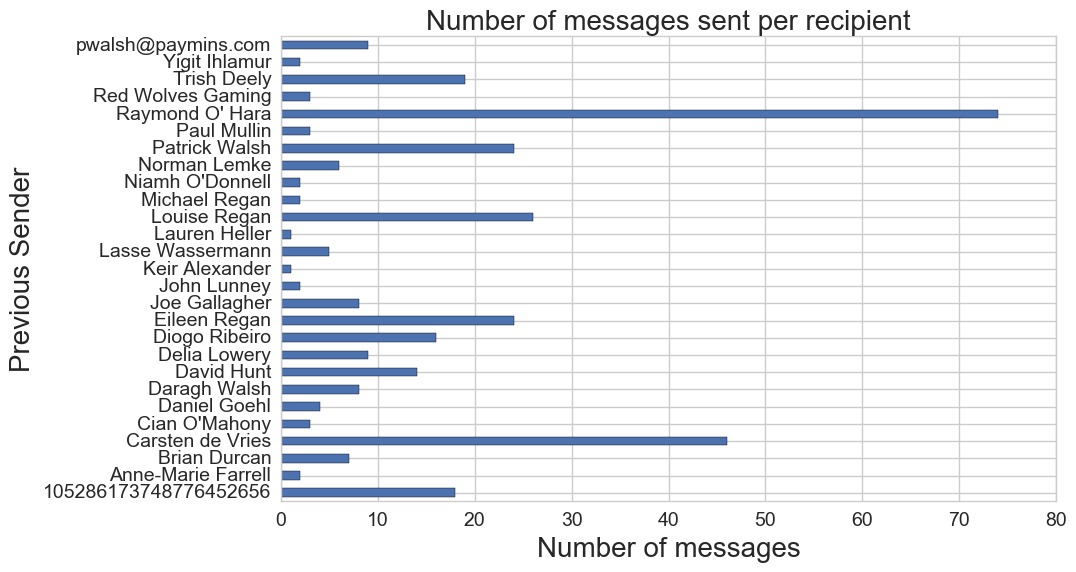

In [128]:
sender_message_cnt = data.groupby('prev_sender')['conversation_id'].count()
sender_message_cnt.plot(kind='barh', figsize=(10,6));
plt.ylabel('Previous Sender');
plt.xlabel('Number of messages');
plt.title('Number of messages sent per recipient')
#plt.xticks(rotation=30)

For each message j and each conversation i, we represent the model as:

$$y_{ji} \sim NegBinomial(\mu_i, \alpha_i)$$
$$\mu_i = Uniform(0, 100)$$
$$\alpha_i = Uniform(0, 100)$$

Estimate individual $\mu_{i}$ and $\alpha_{i}$.

In [143]:
trace_all_senders = {}
senders = data['prev_sender'].unique()
for sender in senders:
    with pm.Model() as model:
        mu = pm.Uniform('mu', lower = 0, upper = 100)
        alpha = pm.Uniform('alpha', lower = 0, upper = 100)
        
        data_current_sender = data[data['prev_sender']==sender]['time_delay_seconds'].values
        
        yest = pm.NegativeBinomial('yest', mu = mu, alpha = alpha, observed = data_current_sender)
        ypred = pm.NegativeBinomial('ypred', mu = mu, alpha = alpha)
        
        start = pm.find_MAP()
        step  = pm.Metropolis()
        
        MH_iter = 200000
        trace = pm.sample(MH_iter, step, start = start, progressbar=True)
        
        trace_all_senders[sender] = trace

INFO (theano.gof.compilelock): Refreshing lock C:\Users\xinliu\AppData\Local\Theano\compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_58_Stepping_9_GenuineIntel-3.5.2-64\lock_dir\lock


Optimization terminated successfully.
         Current function value: 13.406200
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12


100%|████████████████████████████████| 200000/200000 [00:44<00:00, 4486.64it/s]
INFO (theano.gof.compilelock): Refreshing lock C:\Users\xinliu\AppData\Local\Theano\compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_58_Stepping_9_GenuineIntel-3.5.2-64\lock_dir\lock


Optimization terminated successfully.
         Current function value: 104.667962
         Iterations: 10
         Function evaluations: 19
         Gradient evaluations: 19


100%|████████████████████████████████| 200000/200000 [00:53<00:00, 3718.10it/s]
INFO (theano.gof.compilelock): Refreshing lock C:\Users\xinliu\AppData\Local\Theano\compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_58_Stepping_9_GenuineIntel-3.5.2-64\lock_dir\lock


Optimization terminated successfully.
         Current function value: 41.874177
         Iterations: 9
         Function evaluations: 12
         Gradient evaluations: 12


100%|████████████████████████████████| 200000/200000 [00:52<00:00, 3793.08it/s]
INFO (theano.gof.compilelock): Refreshing lock C:\Users\xinliu\AppData\Local\Theano\compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_58_Stepping_9_GenuineIntel-3.5.2-64\lock_dir\lock


Optimization terminated successfully.
         Current function value: 68.015498
         Iterations: 10
         Function evaluations: 13
         Gradient evaluations: 13


100%|████████████████████████████████| 200000/200000 [00:52<00:00, 3787.92it/s]
INFO (theano.gof.compilelock): Refreshing lock C:\Users\xinliu\AppData\Local\Theano\compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_58_Stepping_9_GenuineIntel-3.5.2-64\lock_dir\lock


Optimization terminated successfully.
         Current function value: 80.276497
         Iterations: 12
         Function evaluations: 18
         Gradient evaluations: 18


100%|████████████████████████████████| 200000/200000 [00:53<00:00, 3732.73it/s]
INFO (theano.gof.compilelock): Refreshing lock C:\Users\xinliu\AppData\Local\Theano\compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_58_Stepping_9_GenuineIntel-3.5.2-64\lock_dir\lock


Optimization terminated successfully.
         Current function value: 24.609460
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9


100%|████████████████████████████████| 200000/200000 [00:53<00:00, 3707.20it/s]
INFO (theano.gof.compilelock): Refreshing lock C:\Users\xinliu\AppData\Local\Theano\compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_58_Stepping_9_GenuineIntel-3.5.2-64\lock_dir\lock


Optimization terminated successfully.
         Current function value: 192.109590
         Iterations: 14
         Function evaluations: 21
         Gradient evaluations: 21


100%|████████████████████████████████| 200000/200000 [00:55<00:00, 3604.73it/s]
INFO (theano.gof.compilelock): Refreshing lock C:\Users\xinliu\AppData\Local\Theano\compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_58_Stepping_9_GenuineIntel-3.5.2-64\lock_dir\lock


Optimization terminated successfully.
         Current function value: 32.567790
         Iterations: 9
         Function evaluations: 13
         Gradient evaluations: 13


100%|████████████████████████████████| 200000/200000 [00:53<00:00, 3730.55it/s]
INFO (theano.gof.compilelock): Refreshing lock C:\Users\xinliu\AppData\Local\Theano\compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_58_Stepping_9_GenuineIntel-3.5.2-64\lock_dir\lock


Optimization terminated successfully.
         Current function value: 17.582574
         Iterations: 9
         Function evaluations: 12
         Gradient evaluations: 12


100%|████████████████████████████████| 200000/200000 [00:52<00:00, 3784.86it/s]
INFO (theano.gof.compilelock): Refreshing lock C:\Users\xinliu\AppData\Local\Theano\compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_58_Stepping_9_GenuineIntel-3.5.2-64\lock_dir\lock


Optimization terminated successfully.
         Current function value: 284.202092
         Iterations: 13
         Function evaluations: 22
         Gradient evaluations: 22


100%|████████████████████████████████| 200000/200000 [00:54<00:00, 3677.30it/s]
INFO (theano.gof.compilelock): Refreshing lock C:\Users\xinliu\AppData\Local\Theano\compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_58_Stepping_9_GenuineIntel-3.5.2-64\lock_dir\lock


Optimization terminated successfully.
         Current function value: 17.353356
         Iterations: 7
         Function evaluations: 10
         Gradient evaluations: 10


100%|████████████████████████████████| 200000/200000 [00:52<00:00, 3834.00it/s]
INFO (theano.gof.compilelock): Refreshing lock C:\Users\xinliu\AppData\Local\Theano\compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_58_Stepping_9_GenuineIntel-3.5.2-64\lock_dir\lock


Optimization terminated successfully.
         Current function value: 17.193084
         Iterations: 8
         Function evaluations: 13
         Gradient evaluations: 13


100%|████████████████████████████████| 200000/200000 [00:53<00:00, 3720.18it/s]
INFO (theano.gof.compilelock): Refreshing lock C:\Users\xinliu\AppData\Local\Theano\compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_58_Stepping_9_GenuineIntel-3.5.2-64\lock_dir\lock


Optimization terminated successfully.
         Current function value: 41.192182
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 12


100%|████████████████████████████████| 200000/200000 [00:55<00:00, 3611.10it/s]
INFO (theano.gof.compilelock): Refreshing lock C:\Users\xinliu\AppData\Local\Theano\compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_58_Stepping_9_GenuineIntel-3.5.2-64\lock_dir\lock


Optimization terminated successfully.
         Current function value: 45.749610
         Iterations: 13
         Function evaluations: 15
         Gradient evaluations: 15


100%|████████████████████████████████| 200000/200000 [00:58<00:00, 3415.54it/s]
INFO (theano.gof.compilelock): Refreshing lock C:\Users\xinliu\AppData\Local\Theano\compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_58_Stepping_9_GenuineIntel-3.5.2-64\lock_dir\lock


Optimization terminated successfully.
         Current function value: 74.182915
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10


100%|████████████████████████████████| 200000/200000 [00:56<00:00, 3556.36it/s]
INFO (theano.gof.compilelock): Refreshing lock C:\Users\xinliu\AppData\Local\Theano\compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_58_Stepping_9_GenuineIntel-3.5.2-64\lock_dir\lock


Optimization terminated successfully.
         Current function value: 13.413376
         Iterations: 5
         Function evaluations: 7
         Gradient evaluations: 7


100%|████████████████████████████████| 200000/200000 [00:56<00:00, 3552.11it/s]
INFO (theano.gof.compilelock): Refreshing lock C:\Users\xinliu\AppData\Local\Theano\compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_58_Stepping_9_GenuineIntel-3.5.2-64\lock_dir\lock


Optimization terminated successfully.
         Current function value: 106.889087
         Iterations: 11
         Function evaluations: 17
         Gradient evaluations: 17


100%|████████████████████████████████| 200000/200000 [00:57<00:00, 3470.79it/s]
INFO (theano.gof.compilelock): Refreshing lock C:\Users\xinliu\AppData\Local\Theano\compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_58_Stepping_9_GenuineIntel-3.5.2-64\lock_dir\lock


Optimization terminated successfully.
         Current function value: 22.319761
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12


100%|████████████████████████████████| 200000/200000 [00:55<00:00, 3610.27it/s]
INFO (theano.gof.compilelock): Refreshing lock C:\Users\xinliu\AppData\Local\Theano\compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_58_Stepping_9_GenuineIntel-3.5.2-64\lock_dir\lock


Optimization terminated successfully.
         Current function value: 30.360160
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12


100%|████████████████████████████████| 200000/200000 [00:55<00:00, 3574.07it/s]
INFO (theano.gof.compilelock): Refreshing lock C:\Users\xinliu\AppData\Local\Theano\compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_58_Stepping_9_GenuineIntel-3.5.2-64\lock_dir\lock


Optimization terminated successfully.
         Current function value: 105.827623
         Iterations: 11
         Function evaluations: 14
         Gradient evaluations: 14


100%|████████████████████████████████| 200000/200000 [00:55<00:00, 3621.05it/s]
INFO (theano.gof.compilelock): Refreshing lock C:\Users\xinliu\AppData\Local\Theano\compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_58_Stepping_9_GenuineIntel-3.5.2-64\lock_dir\lock


Optimization terminated successfully.
         Current function value: 45.693848
         Iterations: 10
         Function evaluations: 13
         Gradient evaluations: 13


100%|████████████████████████████████| 200000/200000 [00:55<00:00, 3577.31it/s]
INFO (theano.gof.compilelock): Refreshing lock C:\Users\xinliu\AppData\Local\Theano\compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_58_Stepping_9_GenuineIntel-3.5.2-64\lock_dir\lock


Optimization terminated successfully.
         Current function value: 20.760579
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11


100%|████████████████████████████████| 200000/200000 [00:54<00:00, 3673.40it/s]
INFO (theano.gof.compilelock): Refreshing lock C:\Users\xinliu\AppData\Local\Theano\compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_58_Stepping_9_GenuineIntel-3.5.2-64\lock_dir\lock


Optimization terminated successfully.
         Current function value: 14.745954
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 11


100%|████████████████████████████████| 200000/200000 [00:52<00:00, 3806.13it/s]
INFO (theano.gof.compilelock): Refreshing lock C:\Users\xinliu\AppData\Local\Theano\compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_58_Stepping_9_GenuineIntel-3.5.2-64\lock_dir\lock


Optimization terminated successfully.
         Current function value: 78.049625
         Iterations: 11
         Function evaluations: 17
         Gradient evaluations: 17


100%|████████████████████████████████| 200000/200000 [00:53<00:00, 3706.39it/s]
INFO (theano.gof.compilelock): Refreshing lock C:\Users\xinliu\AppData\Local\Theano\compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_58_Stepping_9_GenuineIntel-3.5.2-64\lock_dir\lock


Optimization terminated successfully.
         Current function value: 38.789383
         Iterations: 12
         Function evaluations: 13
         Gradient evaluations: 13


100%|████████████████████████████████| 200000/200000 [00:54<00:00, 3681.48it/s]
INFO (theano.gof.compilelock): Refreshing lock C:\Users\xinliu\AppData\Local\Theano\compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_58_Stepping_9_GenuineIntel-3.5.2-64\lock_dir\lock


Optimization terminated successfully.
         Current function value: 21.874050
         Iterations: 9
         Function evaluations: 14
         Gradient evaluations: 14


100%|████████████████████████████████| 200000/200000 [00:55<00:00, 3602.85it/s]
INFO (theano.gof.compilelock): Refreshing lock C:\Users\xinliu\AppData\Local\Theano\compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_58_Stepping_9_GenuineIntel-3.5.2-64\lock_dir\lock


Optimization terminated successfully.
         Current function value: 11.316891
         Iterations: 7
         Function evaluations: 9
         Gradient evaluations: 9


100%|████████████████████████████████| 200000/200000 [00:45<00:00, 4364.28it/s]


In [146]:
ix = [3,4,6]

for i, j, p in zip([0,1,2], [0,2,4], senders[ix]):
    print(i, j ,p)

0 0 David Hunt
1 2 Trish Deely
2 4 Carsten de Vries


In [165]:
for i, j, p in zip([0,1,2], [1,3,5], senders[ix]):
    print(i, j, p)

0 1 David Hunt
1 3 Trish Deely
2 5 Carsten de Vries


In [164]:
list(zip([0,1,2], [0,2,4], senders[ix]))

[(0, 0, 'David Hunt'), (1, 2, 'Trish Deely'), (2, 4, 'Carsten de Vries')]

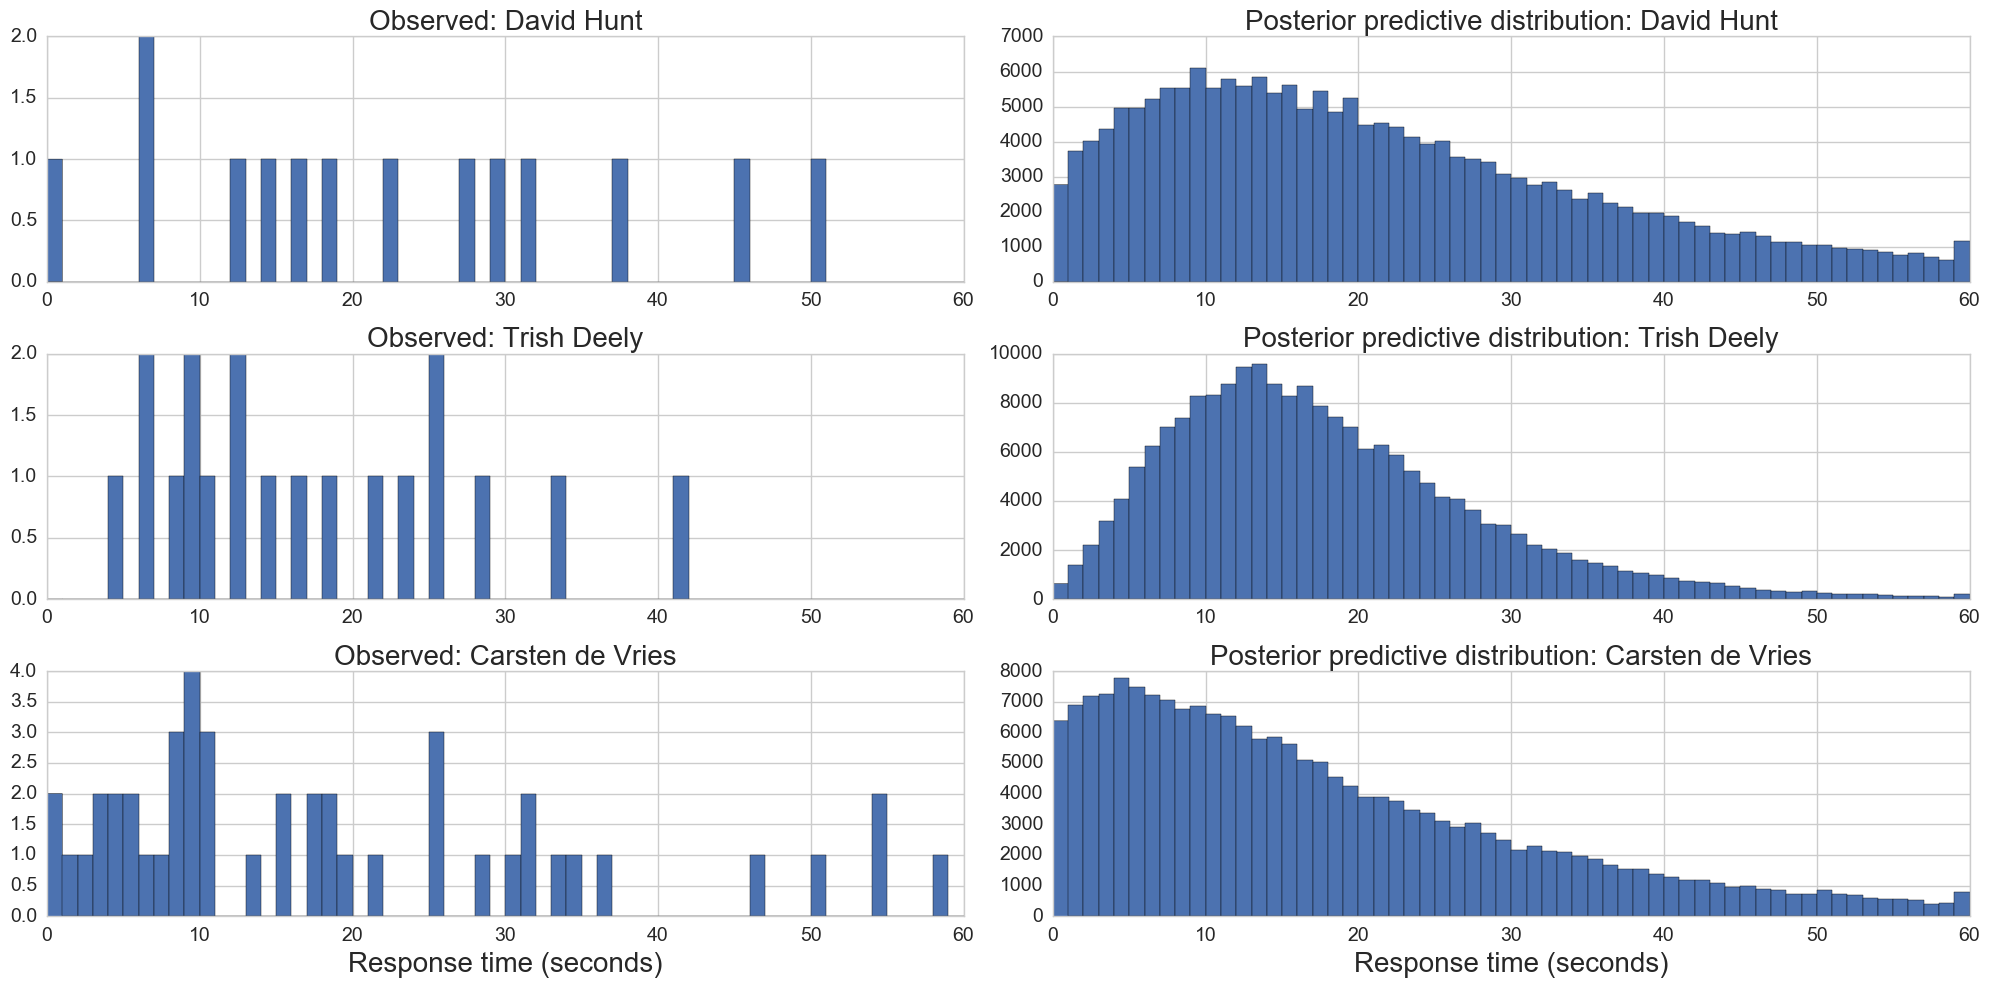

In [166]:
fig, axs = plt.subplots(3,2, figsize=(20, 10))
axs = axs.ravel()
x_lim = 60
idx = [3,4,6]

for i, j, p in zip([0,1,2], [0,2,4], senders[idx]):
    axs[j].set_title('Observed: %s' % p)
    axs[j].hist(data[data['prev_sender']==p]['time_delay_seconds'].values, range=[0, x_lim], bins=x_lim)

for i, j, p in zip([0,1,2], [1,3,5], senders[idx]):
    axs[j].set_title('Posterior predictive distribution: %s' % p)
    axs[j].hist(trace_all_senders[p].get_values('ypred'), range=[0, x_lim], bins=x_lim)

axs[4].set_xlabel('Response time (seconds)')
axs[5].set_xlabel('Response time (seconds)')

plt.tight_layout()

In [167]:
import pickle

save the model we trained

In [168]:
with open('trace_all_senders_pooled.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(trace_all_senders, f, pickle.HIGHEST_PROTOCOL)

way to read in pre-trained model:

In [ ]:
'''
with open('trace_all_senders_pooled.pickle', 'wb') as handle:
    pickle.dump(trace_all_senders, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('trace_all_senders_pooled.pickle', 'rb') as handle:
    trace_all_senders = pickle.load(handle)
'''

The above plots show the observed data (left) and the posterior predictive distribution (right) for 3 example conversations we modeled. The posterior predictive distribution can vary considerably across conversations. This could accurately reflect the characteristics of the conversation or it could be inaccurate due to small sample size.

If we combine the posterior predictive distributions across these models, we would expect this to resemble the distribution of the overall dataset observed. Below perform the posterior predictive check.

In [174]:
ypred_individual = [val[burnin:].get_values('ypred') for key, val in trace_all_senders.items()]
ypred_combined   = np.concatenate(ypred_individual)

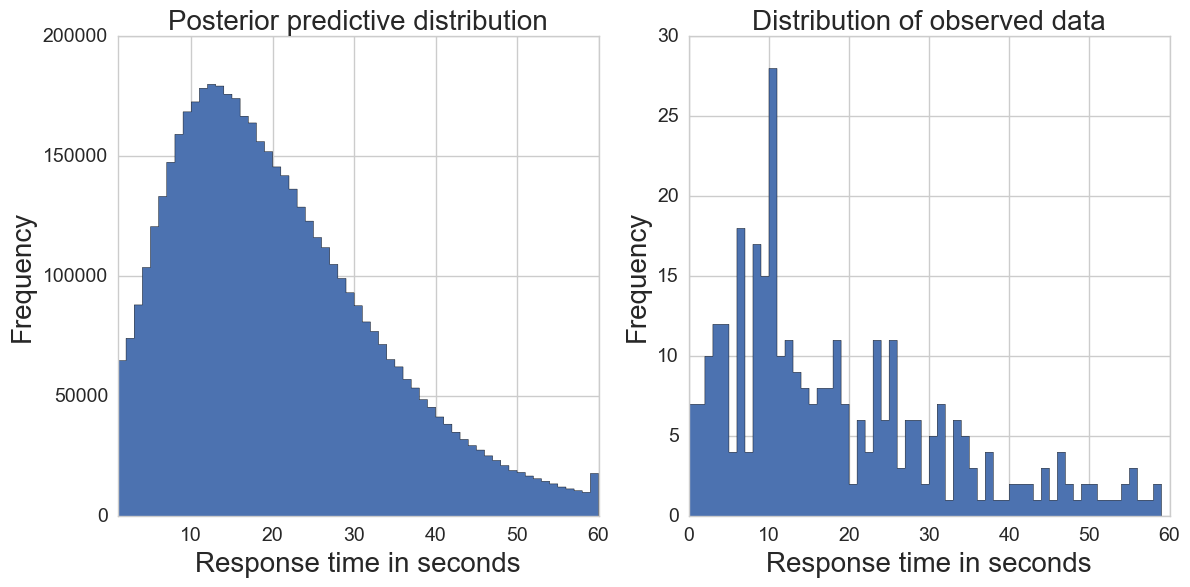

In [190]:
fig = plt.figure(figsize=(12,6))

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

ax1.hist(ypred_combined, range=[0, x_lim], bins=x_lim, histtype='stepfilled')   
ax1.set_xlim(1, x_lim)
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Response time in seconds')
ax1.set_title('Posterior predictive distribution')


ax2.hist(data['time_delay_seconds'].values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
ax2.set_xlim(0, x_lim)
ax2.set_xlabel('Response time in seconds')
ax2.set_ylim(0, 30)
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of observed data')

plt.tight_layout()

The posterior predictive distribution resembles the distribution of the observed data. However, there is a concern that some of the conversations have very little data and hence the estimates are likely to have high variance. One way to mitigate this risk to to share information across conversations - but still estimate $\mu_i$ for each conversation. This is partial pooling.

### Partial pooling
Just like in the pooled model, a partially pooled model has paramater values estimated for each conversation i. However, parameters are connected together via hyperparameters. This reflects our belief that my `response_time`'s per conversation have similarities with one another via user-dependent natural tendancy to respond quickly or slowly.

$$y_{ji} \sim NegBinomial(\mu_i, \alpha_i)$$

Following on from the above example, we will estimate parameter values $(\mu_i)$ and $(\alpha_i)$ for a Negative binomial distribution. Rather than using a uniform prior, I will use a Gamma distribution for both $\mu$ and $\sigma$. This will enable me to introduce more prior knowledge into the model as I have certain expectations as to what vales $\mu$ and $\sigma$ will be.

First, let's have a look at the Gamma distribution. As you can see below, it is very flexible. 

In [191]:
mu = [5, 25, 50]
sd = [3, 7, 2]

In [217]:
rv_size = 10**6
gamma_rvs = {}

with pm.Model() as model:
    for idx, (mu_i, sd_j) in enumerate(zip(mu, sd)):
        gamma_rvs['gamma_rv_'+str(idx)] = pm.Gamma('gamma_rv'+str(idx), mu=mu_i, sd=sd_j).random(size=rv_size)

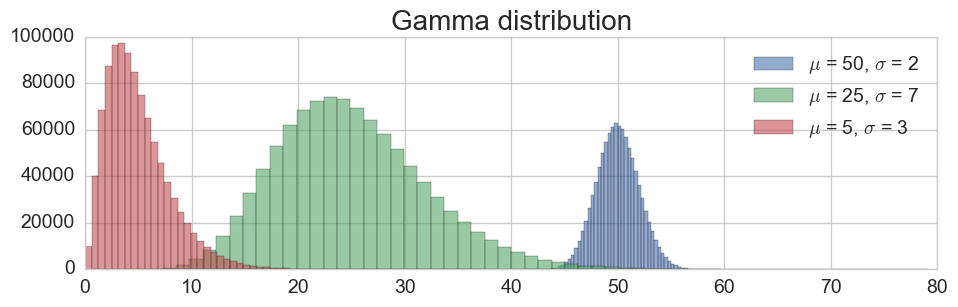

In [222]:
plt.figure(figsize=(11,3))
for key, val in gamma_rvs.items():
    plt.hist(gamma_rvs[key], alpha=0.6, bins = 60)

plt.title('Gamma distribution')
plt.legend(['$\mu$ = %s, $\sigma$ = %s' % (mu[a], sd[a]) for a in [2,1,0]]);

The partially pooled model can be formally described by:

$$y_{ji} \sim NegBinomial(\mu_i, \alpha_i)$$
$$\mu_i = Gamma(\mu_\mu, \sigma_\mu)$$
$$\alpha_i = Gamma(\mu_\alpha, \sigma_\alpha)$$
$$\mu_\mu = Uniform(0, 60)$$
$$\sigma_\mu = Uniform(0, 50)$$
$$\mu_\alpha = Uniform(0, 10)$$
$$\sigma_\alpha = Uniform(0, 50)$$

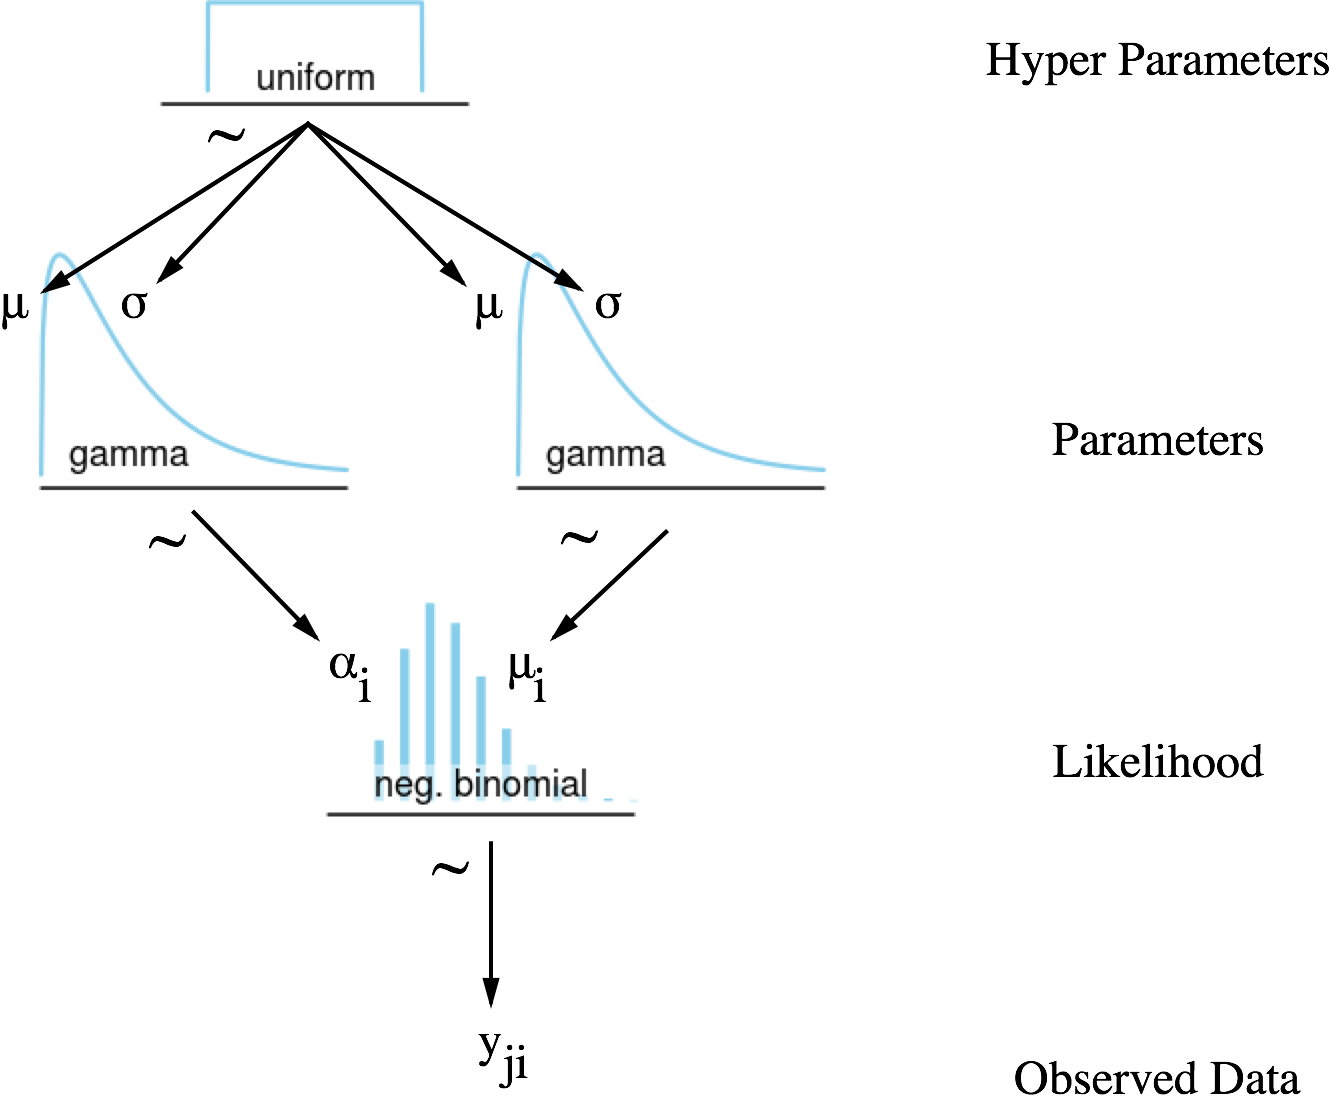

In [223]:
Image('dag neg poisson gamma hyper.png', width=420)

In [227]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
sender_idx = LE.fit_transform(data['prev_sender'])
n_sender = len(np.unique(sender_idx))

In [239]:
with pm.Model() as model:
    hyper_alpha_sd = pm.Uniform('hyper_alpha_sd', lower=0, upper=50)
    hyper_alpha_mu = pm.Uniform('hyper_alpha_mu', lower=0, upper=10)
    
    hyper_mu_sd = pm.Uniform('hyper_mu_sd', lower=0, upper=50)
    hyper_mu_mu = pm.Uniform('hyper_mu_mu', lower=0, upper=60)
    
    alpha = pm.Gamma('alpha', mu=hyper_alpha_mu, sd=hyper_alpha_sd, shape=n_sender)
    mu = pm.Gamma('mu', mu=hyper_mu_mu, sd=hyper_mu_sd, shape=n_sender)
    
    y_est = pm.NegativeBinomial('y_est', 
                                mu=mu[sender_idx], 
                                alpha=alpha[sender_idx], 
                                observed=data['time_delay_seconds'].values)
    
    y_pred = pm.NegativeBinomial('y_pred', 
                                 mu=mu[sender_idx], 
                                 alpha=alpha[sender_idx],
                                 shape=data['prev_sender'].shape)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    hierarchical_trace_og = pm.sample(200000, step, progressbar=True)

INFO (theano.gof.compilelock): Refreshing lock C:\Users\xinliu\AppData\Local\Theano\compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_58_Stepping_9_GenuineIntel-3.5.2-64\lock_dir\lock


         Current function value: 2176.665275
         Iterations: 246
         Function evaluations: 340
         Gradient evaluations: 328


100%|█████████████████████████████████| 200000/200000 [04:10<00:00, 799.20it/s]


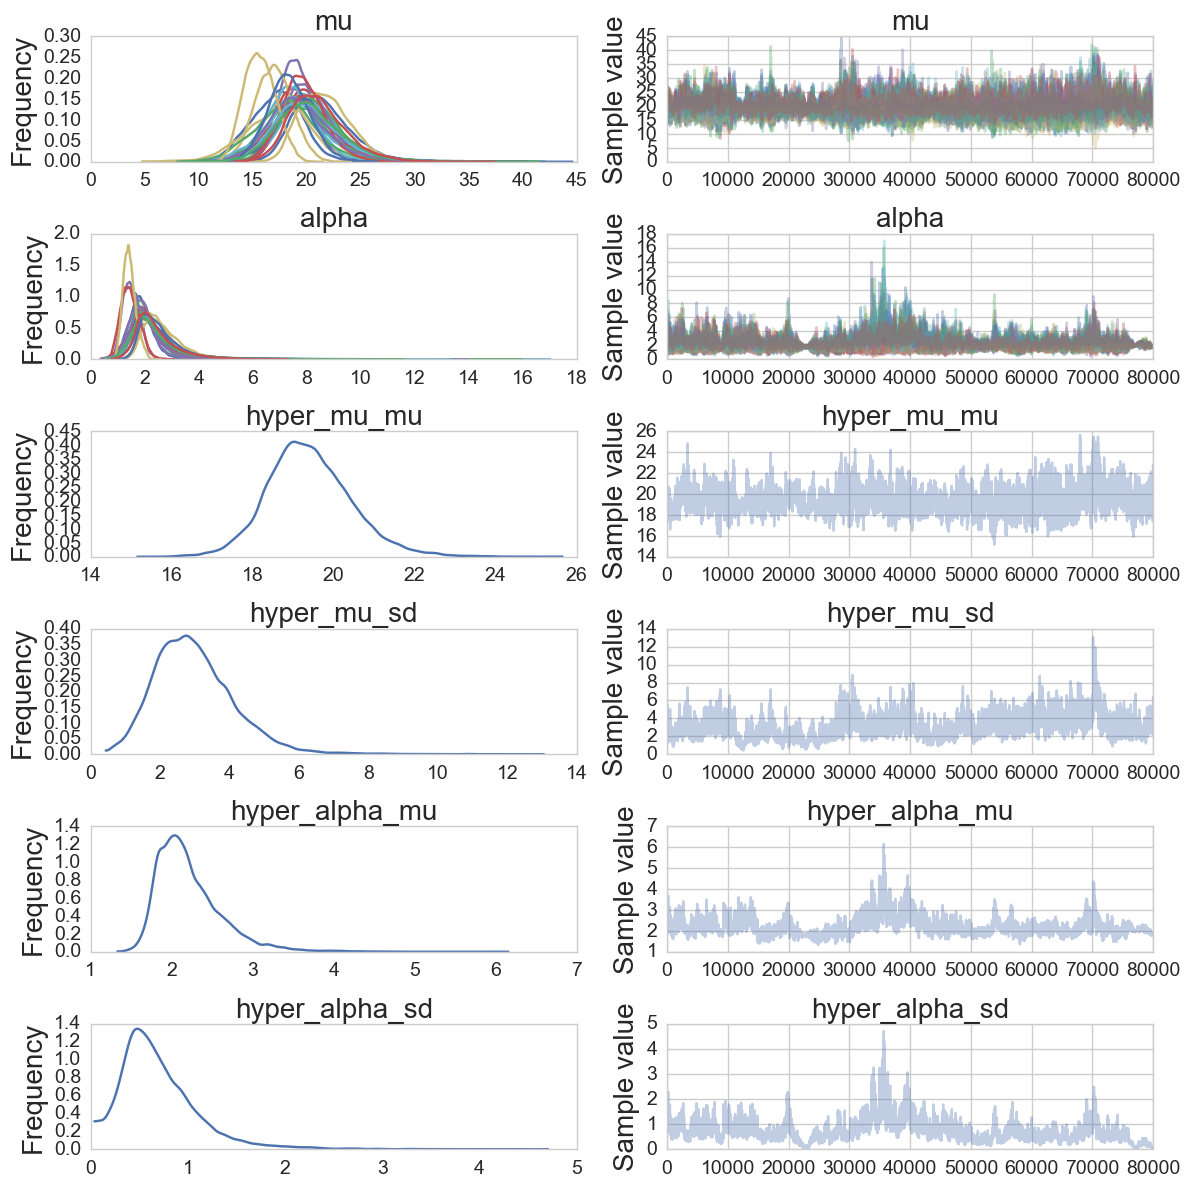

In [242]:
pm.traceplot(hierarchical_trace_og[120000:], 
                 varnames=['mu','alpha','hyper_mu_mu',
                           'hyper_mu_sd','hyper_alpha_mu',
                           'hyper_alpha_sd']);

In [237]:
with pm.Model() as model:
    # define the hyper-parameter for negative binomial parameter alpha
    nb_alpha_gamma_mu = pm.Uniform('nb_alpha_gamma_mu', lower = 0, upper = 10)
    nb_alpha_gamma_sd = pm.Uniform('nb_alpha_gamma_sd', lower = 0, upper = 50)
    
    # define the hyper-parameter for negative binomial parameter mu
    nb_mu_gamma_mu = pm.Uniform('nb_mu_gamma_mu', lower = 0, upper = 10)
    nb_mu_gamma_sd = pm.Uniform('nb_mu_gamma_sd', lower = 0, upper = 50)
    
    # define the parameter for negative binomial(mu, alpha) -- alpha ~ Gamma(mu, sd) --- shape
    nb_alpha = pm.Gamma('nb_alpha', mu = nb_alpha_gamma_mu, sd = nb_alpha_gamma_sd, shape=n_sender)
    
    # define the parameter for negative binomial(mu, alpha) -- mu ~ Gamma(mu, sd) --- shape
    nb_mu = pm.Gamma('nb_mu', mu = nb_mu_gamma_mu, sd = nb_mu_gamma_sd, shape=n_sender)
    
    # define the likelihood function
    yest = pm.NegativeBinomial('yest', mu = nb_mu[sender_idx], alpha = nb_alpha[sender_idx], \
                               observed = data['time_delay_seconds'].values)
    
    # define the predictive output functin -- shape
    ypred = pm.NegativeBinomial('ypred', mu = nb_mu[sender_idx], alpha = nb_alpha[sender_idx], \
                                shape=data['prev_sender'].shape)
    
    # starting point
    start = pm.find_MAP()
    
    # sampler -- MH
    step  = pm.Metropolis()
    
    # sampling
    MH_iter = 200000
    hierarchical_trace = pm.sample(MH_iter, step, start = start, progressbar=True)

INFO (theano.gof.compilelock): Refreshing lock C:\Users\xinliu\AppData\Local\Theano\compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_58_Stepping_9_GenuineIntel-3.5.2-64\lock_dir\lock


         Current function value: 1837.233527
         Iterations: 245
         Function evaluations: 331
         Gradient evaluations: 321


100%|█████████████████████████████████| 200000/200000 [04:07<00:00, 806.79it/s]


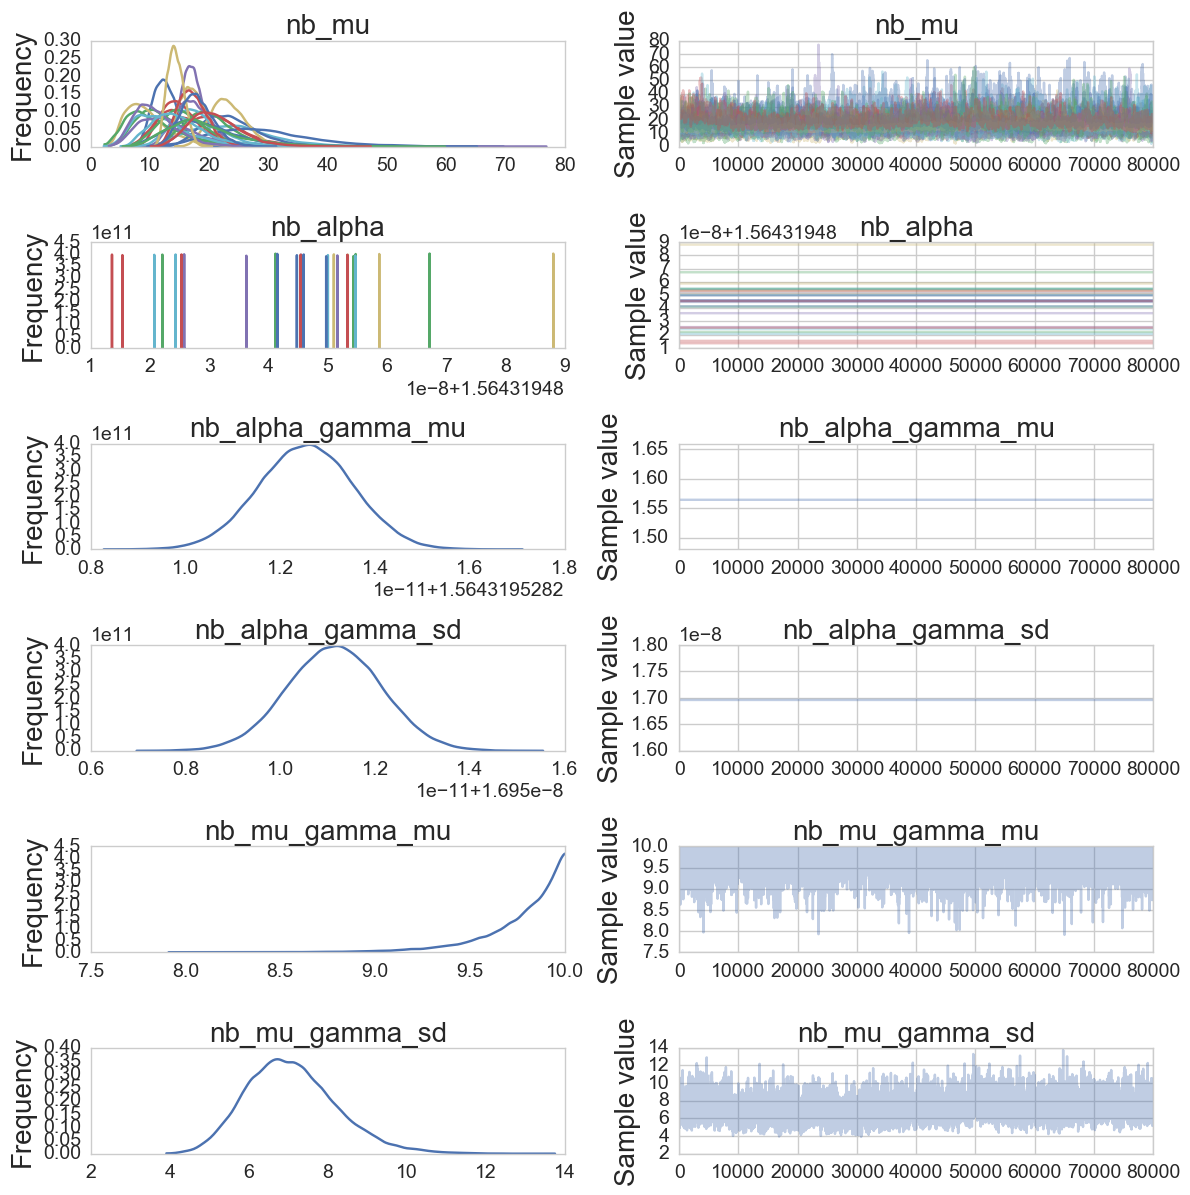

In [238]:
burnin = 100000
pm.traceplot(hierarchical_trace[120000:], 
             varnames=['nb_mu','nb_alpha',\
                       'nb_alpha_gamma_mu','nb_alpha_gamma_sd',\
                       'nb_mu_gamma_mu','nb_mu_gamma_sd']);

You can see for the estimates of $\mu$ and $\alpha$ that we have multiple plots - one for each conversation i. The difference between the pooled and the partially pooled model is that the parameters of the partially pooled model ($\mu_i$ and $\alpha_i$) have a hyperparameter that is shared across all conversations i. This brings two benefits:
1. Information is shared across conversations, so for conversations that have limited sample size, they "borrow" knowledge from other conversations during estimation to help reduce the variance of the estimate
2. We get an estimate for each conversation and an overall estimate for all conversations

Let's have a quick look at the posterior predictive distribution.

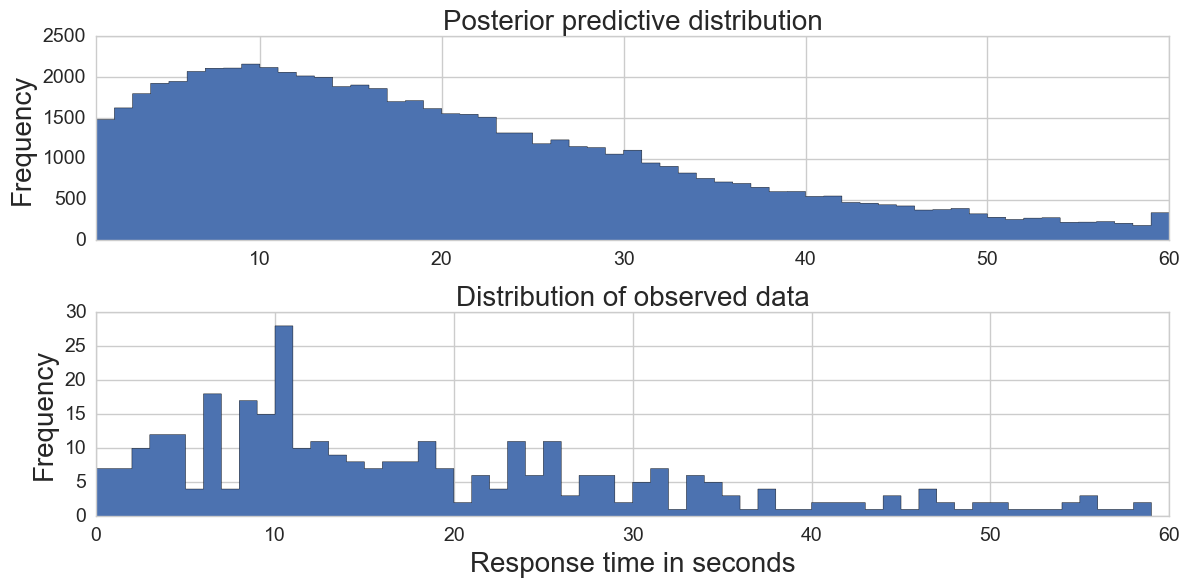

In [249]:
x_lim = 60
ypred = hierarchical_trace_og.get_values('y_pred')[::1000].ravel()

fig = plt.figure(figsize=(12,6))
fig.add_subplot(211)

fig.add_subplot(211)

_ = plt.hist(ypred, range=[0, x_lim], bins=x_lim, histtype='stepfilled')   
_ = plt.xlim(1, x_lim)
_ = plt.ylabel('Frequency')
_ = plt.title('Posterior predictive distribution')

fig.add_subplot(212)

_ = plt.hist(data['time_delay_seconds'].values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
_ = plt.xlabel('Response time in seconds')
_ = plt.ylabel('Frequency')
_ = plt.title('Distribution of observed data')

plt.tight_layout()

### Shrinkage effect: pooled vs hierarchical model
As discussed, the partially pooled model shared a hyperparameter for both $\mu$ and $\alpha$. By sharing knowledge across conversations, it has the effect of shrinking the estimates closer together - particularly for conversations that have little data.

This shrinkage effect is illustrated in the below plot. You can see how the $\mu$ and $\alpha$ parameters are drawn together by the effect of the hyperparameter.

In [243]:
with open('trace_all_senders_pooled.pickle', 'rb') as handle:
    indiv_traces = pickle.load(handle)

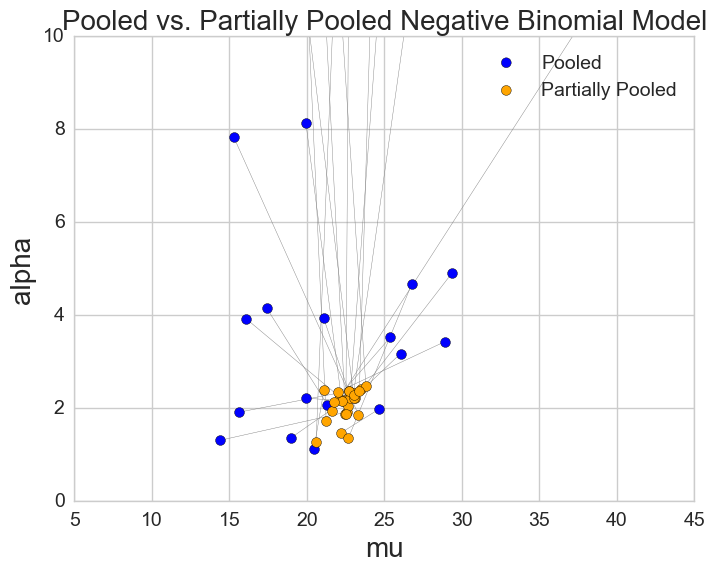

In [247]:
hier_mu = hierarchical_trace_og['mu'][500:].mean(axis=0)
hier_alpha = hierarchical_trace_og['alpha'][500:].mean(axis=0)
indv_mu = [indiv_traces[p]['mu'][500:].mean() for p in senders]
indv_alpha = [indiv_traces[p]['alpha'][500:].mean() for p in senders]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, xlabel='mu', ylabel='alpha', 
                     title='Pooled vs. Partially Pooled Negative Binomial Model', 
                     xlim=(5, 45), ylim=(0, 10))

ax.scatter(indv_mu, indv_alpha, s=50, c = 'blue', label = 'Pooled', zorder=3)
ax.scatter(hier_mu, hier_alpha, s=50, c = 'orange', label = 'Partially Pooled', zorder=4)
for i in range(len(indv_mu)):  
    ax.arrow(indv_mu[i], indv_alpha[i], hier_mu[i] - indv_mu[i], hier_alpha[i] - indv_alpha[i], 
            fc="grey", ec="grey", length_includes_head=True, alpha=.5, head_width=0)

_ = ax.legend()

### Asking questions of the posterior
Let's start to take advantage of one of the best aspects of Bayesian statistics - the posterior distribution. Unlike frequentist techniques, we get a full posterior distribution as opposed to a single point estimate. In essence, we have a basket full of credible parameter values. This enables us to ask some questions in a fairly natural and intuitive manner.

#### What are the chances I'll respond to my friend in less than 10 seconds?
To estimate this probability, we can look at the posterior predctive distribution for Timothy & Andrew's `response_time` and check how many of the samples are < 10 seconds. When I first heard of this technique, I thought I misunderstood because it seemed overly simplistic. 

In [250]:
def senders_y_pred(person):
    """Return posterior predictive for person"""
    ix = np.where(senders == person)[0][0]
    return hierarchical_trace_og['y_pred'][100000:, ix]

In [253]:
print("Here are some samples from Timothy's posterior predictive distribution: \n %s" % senders_y_pred('Joe Gallagher'))

Here are some samples from Timothy's posterior predictive distribution: 
 [21 21 21 ..., 18 18 18]


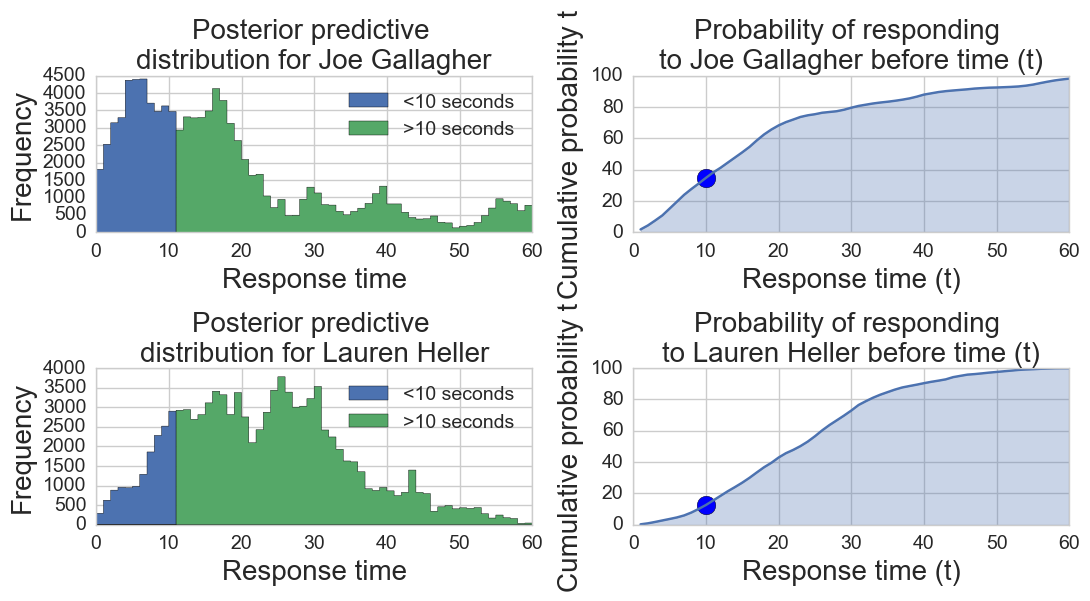

In [258]:
def person_plotA(person_name):
    ix_check = senders_y_pred(person_name) > 10
    _ = plt.hist(senders_y_pred(person_name)[~ix_check], range=[0, x_lim], bins=x_lim, histtype='stepfilled', label='<10 seconds')
    _ = plt.hist(senders_y_pred(person_name)[ix_check], range=[0, x_lim], bins=x_lim, histtype='stepfilled', label='>10 seconds')
    _ = plt.title('Posterior predictive \ndistribution for %s' % person_name)
    _ = plt.xlabel('Response time')
    _ = plt.ylabel('Frequency')
    _ = plt.legend()

def person_plotB(person_name):
    x = np.linspace(1, 60, num=60)
    num_samples = float(len(senders_y_pred(person_name)))
    prob_lt_x = [100*sum(senders_y_pred(person_name) < i)/num_samples for i in x]
    _ = plt.plot(x, prob_lt_x)
    _ = plt.fill_between(x, prob_lt_x, alpha=0.3)
    _ = plt.scatter(10, float(100*sum(senders_y_pred(person_name) < 10))/num_samples, s=180)
    _ = plt.title('Probability of responding \nto %s before time (t)' % person_name)
    _ = plt.xlabel('Response time (t)')
    _ = plt.ylabel('Cumulative probability t')
    _ = plt.ylim(ymin=0, ymax=100)
    _ = plt.xlim(xmin=0, xmax=60)

fig = plt.figure(figsize=(11,6))
_ = fig.add_subplot(221)
person_plotA('Joe Gallagher')
_ = fig.add_subplot(222)
person_plotB('Joe Gallagher')

_ = fig.add_subplot(223)
person_plotA('Lauren Heller')
_ = fig.add_subplot(224)
person_plotB('Lauren Heller')

plt.tight_layout()

I find this methodology to be very intuitive and flexible. The plot above left separates the samples from the posterior predictive in terms of being greater than or less than 10 seconds. We can compute the probability by calculating the proportion of samples that are less than 10. The plot on the right simply computes this probability for each response time value from 0 to 60. So, it looks like Anna & Yonas have a 36% & 20% chance of being responded to in less than 10 seconds, respectively.

#### How do my friends pair off against each other?

In [260]:
def prob_persona_faster(persona, personb):
    return np.float(sum(senders_y_pred(persona) < senders_y_pred(personb)))/len(senders_y_pred(persona))

print("Probability that Tom is responded to faster than Andrew: {:.2%}"\
      .format(prob_persona_faster('Joe Gallagher', 'Lauren Heller')))

Probability that Tom is responded to faster than Andrew: 67.78%


In [261]:
import itertools

In [263]:
# Create an empty dataframe
ab_dist_df = pd.DataFrame(index=senders, columns=senders, dtype=np.float)

# populate each cell in dataframe with persona_less_personb()
for a, b in itertools.permutations(senders, 2):
    ab_dist_df.ix[a, b] = prob_persona_faster(a, b)
    
# populate the diagonal
for a in senders:
    ab_dist_df.ix[a, a] = 0.5

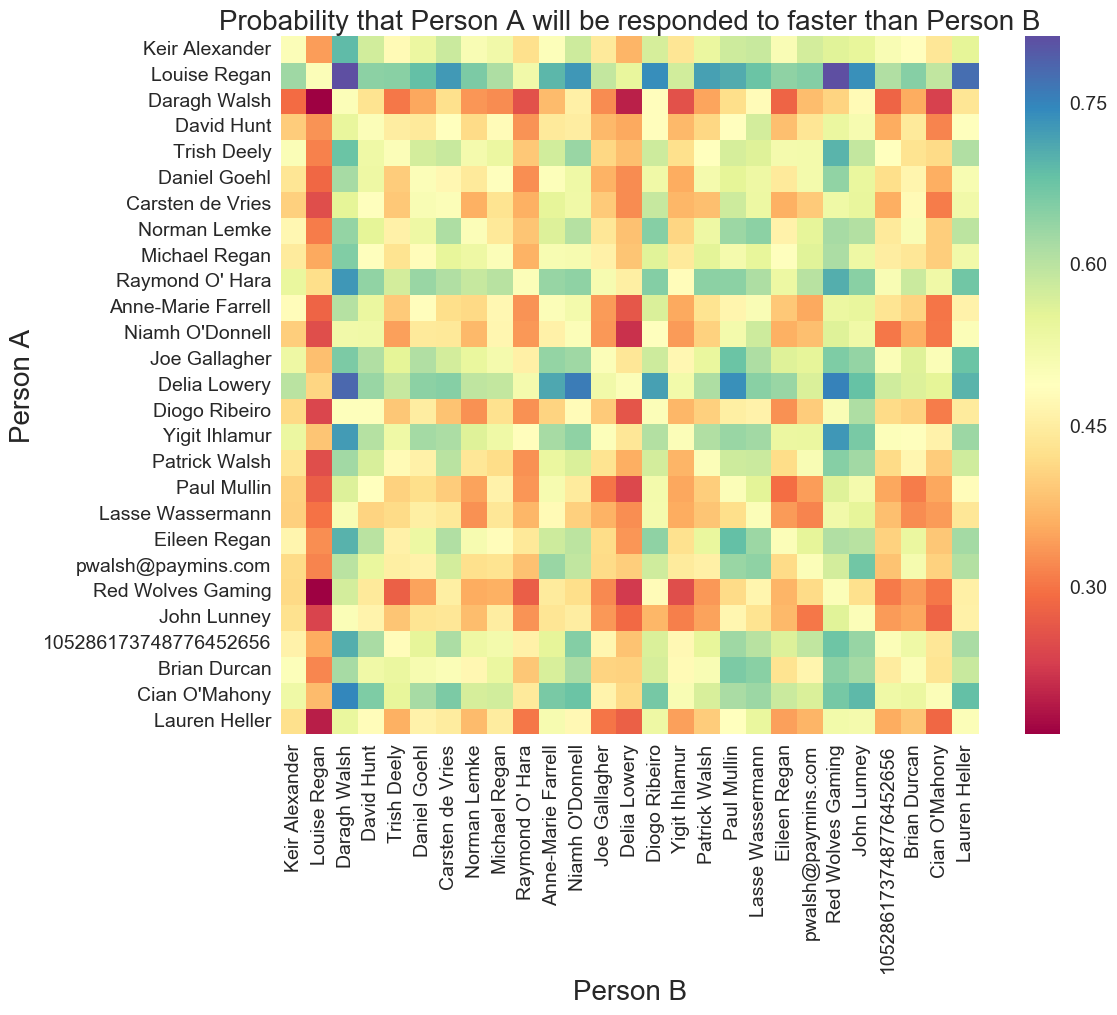

In [264]:
# Plot heatmap
f, ax = plt.subplots(figsize=(12, 9))
cmap = plt.get_cmap("Spectral")
_ = sns.heatmap(ab_dist_df, square=True, cmap=cmap)
_ = plt.title('Probability that Person A will be responded to faster than Person B')
_ = plt.ylabel('Person A')
_ = plt.xlabel('Person B')

In [ ]:
with open('hierarchical_trace_partialPooled.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(hierarchical_trace_og, f, pickle.HIGHEST_PROTOCOL)